# Продвинутое машинное обучение: ДЗ 1
### Герасимчик Анна. ML-22

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import json
import math
from datetime import date
import numpy as np
import pandas as pd
import scipy as sp
import scipy.stats as st
import scipy.integrate as integrate
from sklearn.linear_model import LinearRegression
from scipy.stats import multivariate_normal
from sklearn.exceptions import ConvergenceWarning
import statsmodels.api as sm

sns.set_style("whitegrid")
sns.set_palette("colorblind")
palette = sns.color_palette()
figsize = (15,8)
legend_fontsize = 16

from matplotlib import rc
rc('font',**{'family':'sans-serif'})
rc('figure', **{'dpi': 300})

## Часть I: О теореме Байеса

Первая часть состоит из двух вопросов и одного задания. Смысл её в том, чтобы провести вероятностные рассуждения в ситуациях, когда модель сама по себе очень простая, но её ещё надо правильно построить, правильно отобразить жизненную ситуацию. Поэтому на первые два вопроса рекомендую давать развёрнутые ответы; эти ответы лучше писать прямо в ноутбуке, LaTeX в jupyter работает на вполне достаточном для нас уровне.

### 1

Произошло убийство. На месте убийства найдена кровь, которая явно (будем считать, что с вероятностью 1) принадлежит настоящему убийце. Кровь принадлежит редкой группе, которая присутствует всего лишь у 1% населения. И так получилось, что у подсудимого как раз эта редкая группа крови!
Первым выходит прокурор и говорит: “Шанс, что у подсудимого была бы именно такая группа крови, если бы он был невиновен -- всего 1%; значит, с вероятностью 99% он виновен, предлагаю осудить”. В чём не прав прокурор? Укажите, какие вероятности он оценил, а какие должен был оценить.

Решение:

$I$="Подсудимый виновен"

$E$="Группа крови убийцы, найденная на месте преступления, совпадает с группой крови подсудимого"

В городе живет 1 миллион человек, и один из них убийца. Значит, $P(\overline{I})=\frac{1}{10^6}, P(I)=1-P(\overline{I})=\frac{999999}{10^6}.$ На месте убийства найдена кровь, которая явно принадлежит настоящему убийце. Имеем, $P(E\mid{\overline{I}})=1.$ Кровь принадлежит редкой группе, которая присутствует всего лишь у 1% населения. Следовательно, $P(E\mid{I})=1\%=0.01.$

Теперь у нас есть все нужные данные для подсчета $P(I\mid{E})$.

$P(I\mid{E})=\frac{P(E\mid{I})P(I)}{P(E)}=\frac{P(E\mid{I})P(I)}{P(E\mid{I}){P(I)}+P(E\mid{\overline{I}}){P(\overline{I})}}=\frac{0.01\cdot{\frac{999999}{10^6}}}{0.01\cdot{\frac{999999}{10^6}}+1\cdot{\frac{1}{10^6}}}=\frac{0.00999999}{0.01000099}=0.9999=99.99\%$

Значит, вероятность того, что подсудимый виновен, имея редкую группу крови, совпадающую с группой крови, найденной на месте преступления, ничтожно мала.

Прокурор считает, что $P(\overline{I}\mid{E})=1-P(I\mid{E})=1-P(E\mid{I})=1-0.01=0.99=99\%$. Но $P(I\mid{E})\neq{P(E\mid{I})}.$

### 2

Затем выходит адвокат, объясняет ошибки прокурора и берёт слово сам: “В городе живёт миллион человек. Это значит, что примерно у 10000 из них такая группа крови. Значит, всё, что говорит нам эта кровь -- это то, что подсудимый совершил убийство с вероятностью 0.01%. Получается, что это свидетельство не просто не является строгим доказательством, а и вовсе даёт нам ничтожно малую вероятность того, что мой подзащитный виновен, так что предлагаю исключить его из материалов дела”. В чём не прав адвокат? Какие вероятности он оценил, а какие должен был оценить?

Адвокат посчитал вероятности правильно, но не учел тот факт, что $P(\overline{I}\mid{E})=0.01\%$ только в том случае, если нет никаких доказательств кроме совпадающей группы крови, связывающих подсудимого с преступлением. Но обычно будут и другие доказательства (ведь подсудимого арестовали), которые могут исключить значительную часть подозреваемых из исходных 10 тысяч.
Также данную улику совершенно точно нельзя исключать из материалов дела, так как независимо от других доказательств, соответствующая группа крови увеличила вероятность вины в 100 раз. А это очень существенно.

### 3

Вернёмся к тесту на страшную болезнь из первой лекции. Напомню, что по предположениям задачи болеет 1% населения, а тест имеет вероятность ошибки 5% в обе стороны. Мы видели, что в результате человек с положительным тестом имеет апостериорную вероятность оказаться больным всего лишь около 16%.
Врачи решили, что терпеть это никак нельзя; они готовы провести срочное исследование и улучшить качество теста. Но сил и денег хватит только для того, чтобы сократить один тип ошибок, т.е. уменьшить или только число false positives (когда тест выдаёт положительный результат у здорового человека), или только число false negatives (когда тест выдаёт отрицательный результат у больного).
Помогите медикам: постройте зависимости апостериорной вероятности болезни после положительного и отрицательного теста от обоих видов ошибок (например, в виде графиков), сделайте выводы и дайте рекомендации врачам -- на чём лучше сосредоточиться?

Пусть $P(t=1\mid{d=0})=x-$false positive, $P(t=0\mid{d=1})=y-$false negative. Тогда:

$P(d=1\mid{t=1})=\frac{P(t=1\mid{d=1})P(d=1)}{P(t=1)}=\frac{P(t=1\mid{d=1})P(d=1)}{P(t=1\mid{d=0})P(d=0)+P(t=1\mid{d=1})P(d=1)}=\frac{(1-y)P(d=1)}{xP(d=0)+(1-y)P(d=1)}=\frac{0.01(1-y)}{0.99x+0.01(1-y)}$

$P(d=1\mid{t=0})=\frac{P(t=0\mid{d=1})P(d=1)}{P(t=0)}=\frac{P(t=0\mid{d=1})P(d=1)}{P(t=0\mid{d=0})P(d=0)+P(t=0\mid{d=1})P(d=1)}=\frac{yP(d=1)}{(1-x)P(d=0)+yP(d=1)}=\frac{0.01y}{0.99(1-x)+0.01y}$

In [2]:
def show_probability_plot(curve):
    p = np.arange(0, 1.001, 0.001)
    
    predict_1 = curve(x=p)
    predict_2 = curve(y=p)

    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111)
    ax.set_xlim(p[0], p[-1])
    ax.set_ylim(p[0], p[-1])

    ax.plot(p, predict_1, linewidth=2, label="FP changes", color=palette[4])
    ax.plot(p, predict_2, linewidth=2, label="FN changes", color=palette[2])

    ax.legend(loc="upper center", fontsize=legend_fontsize)
    plt.show()

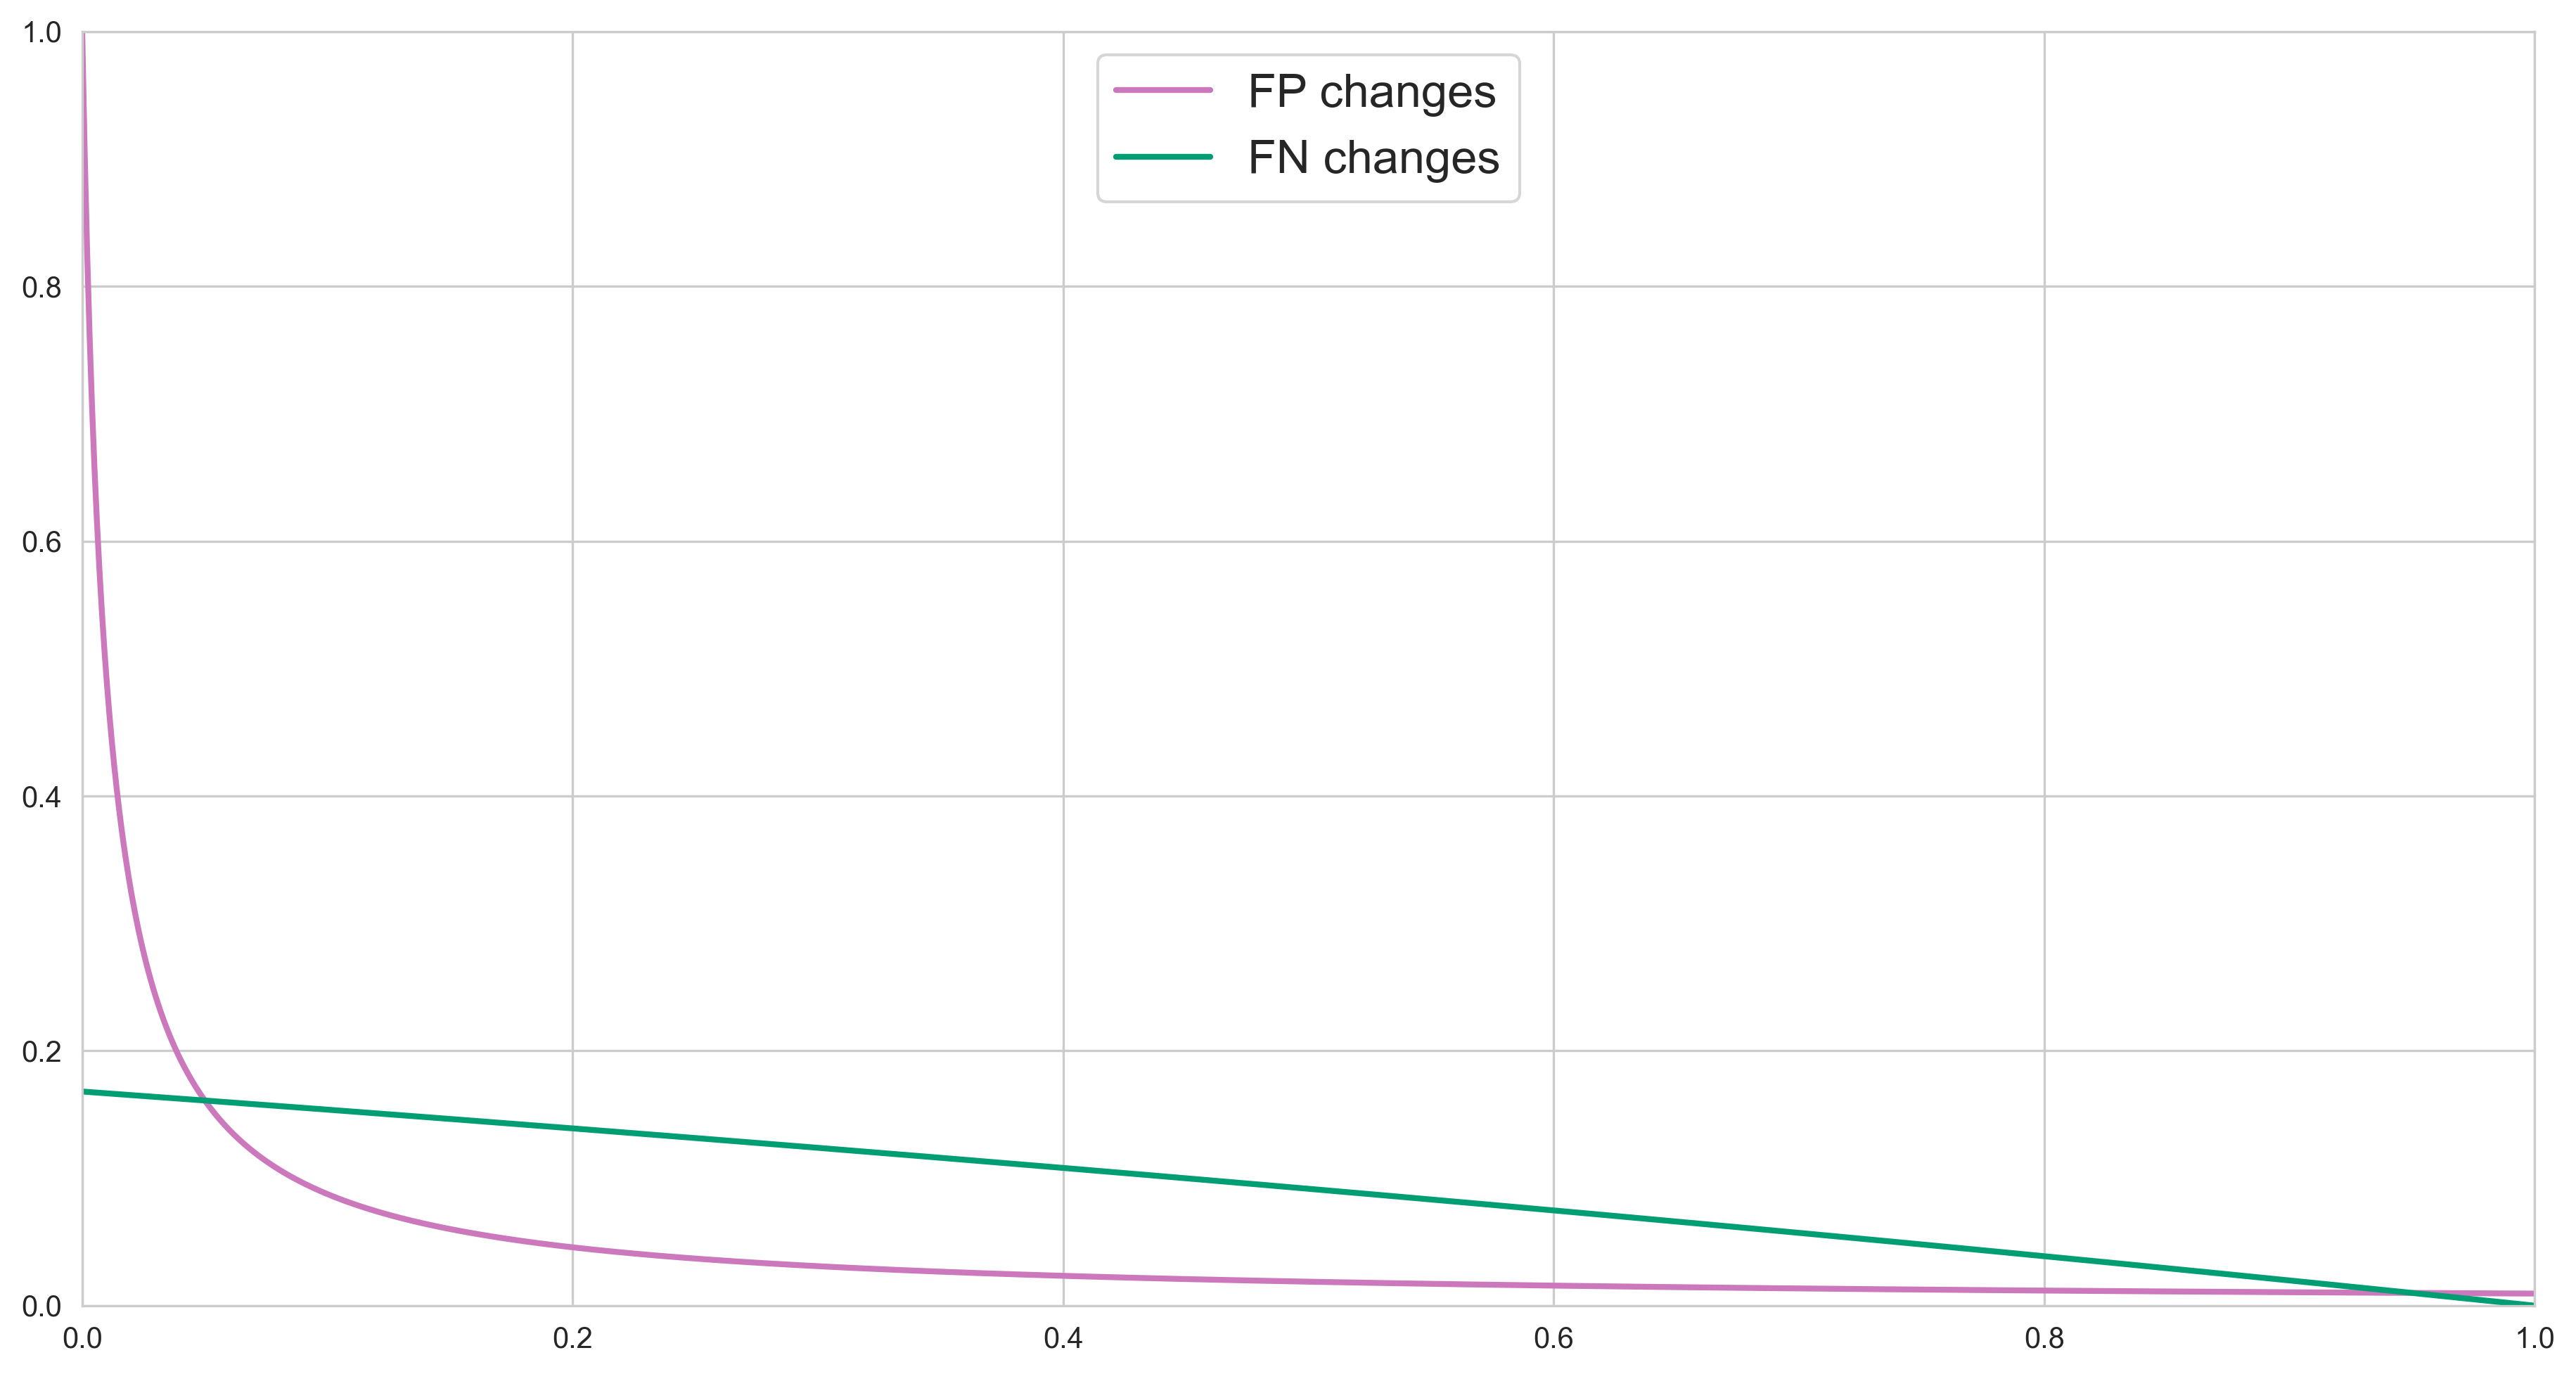

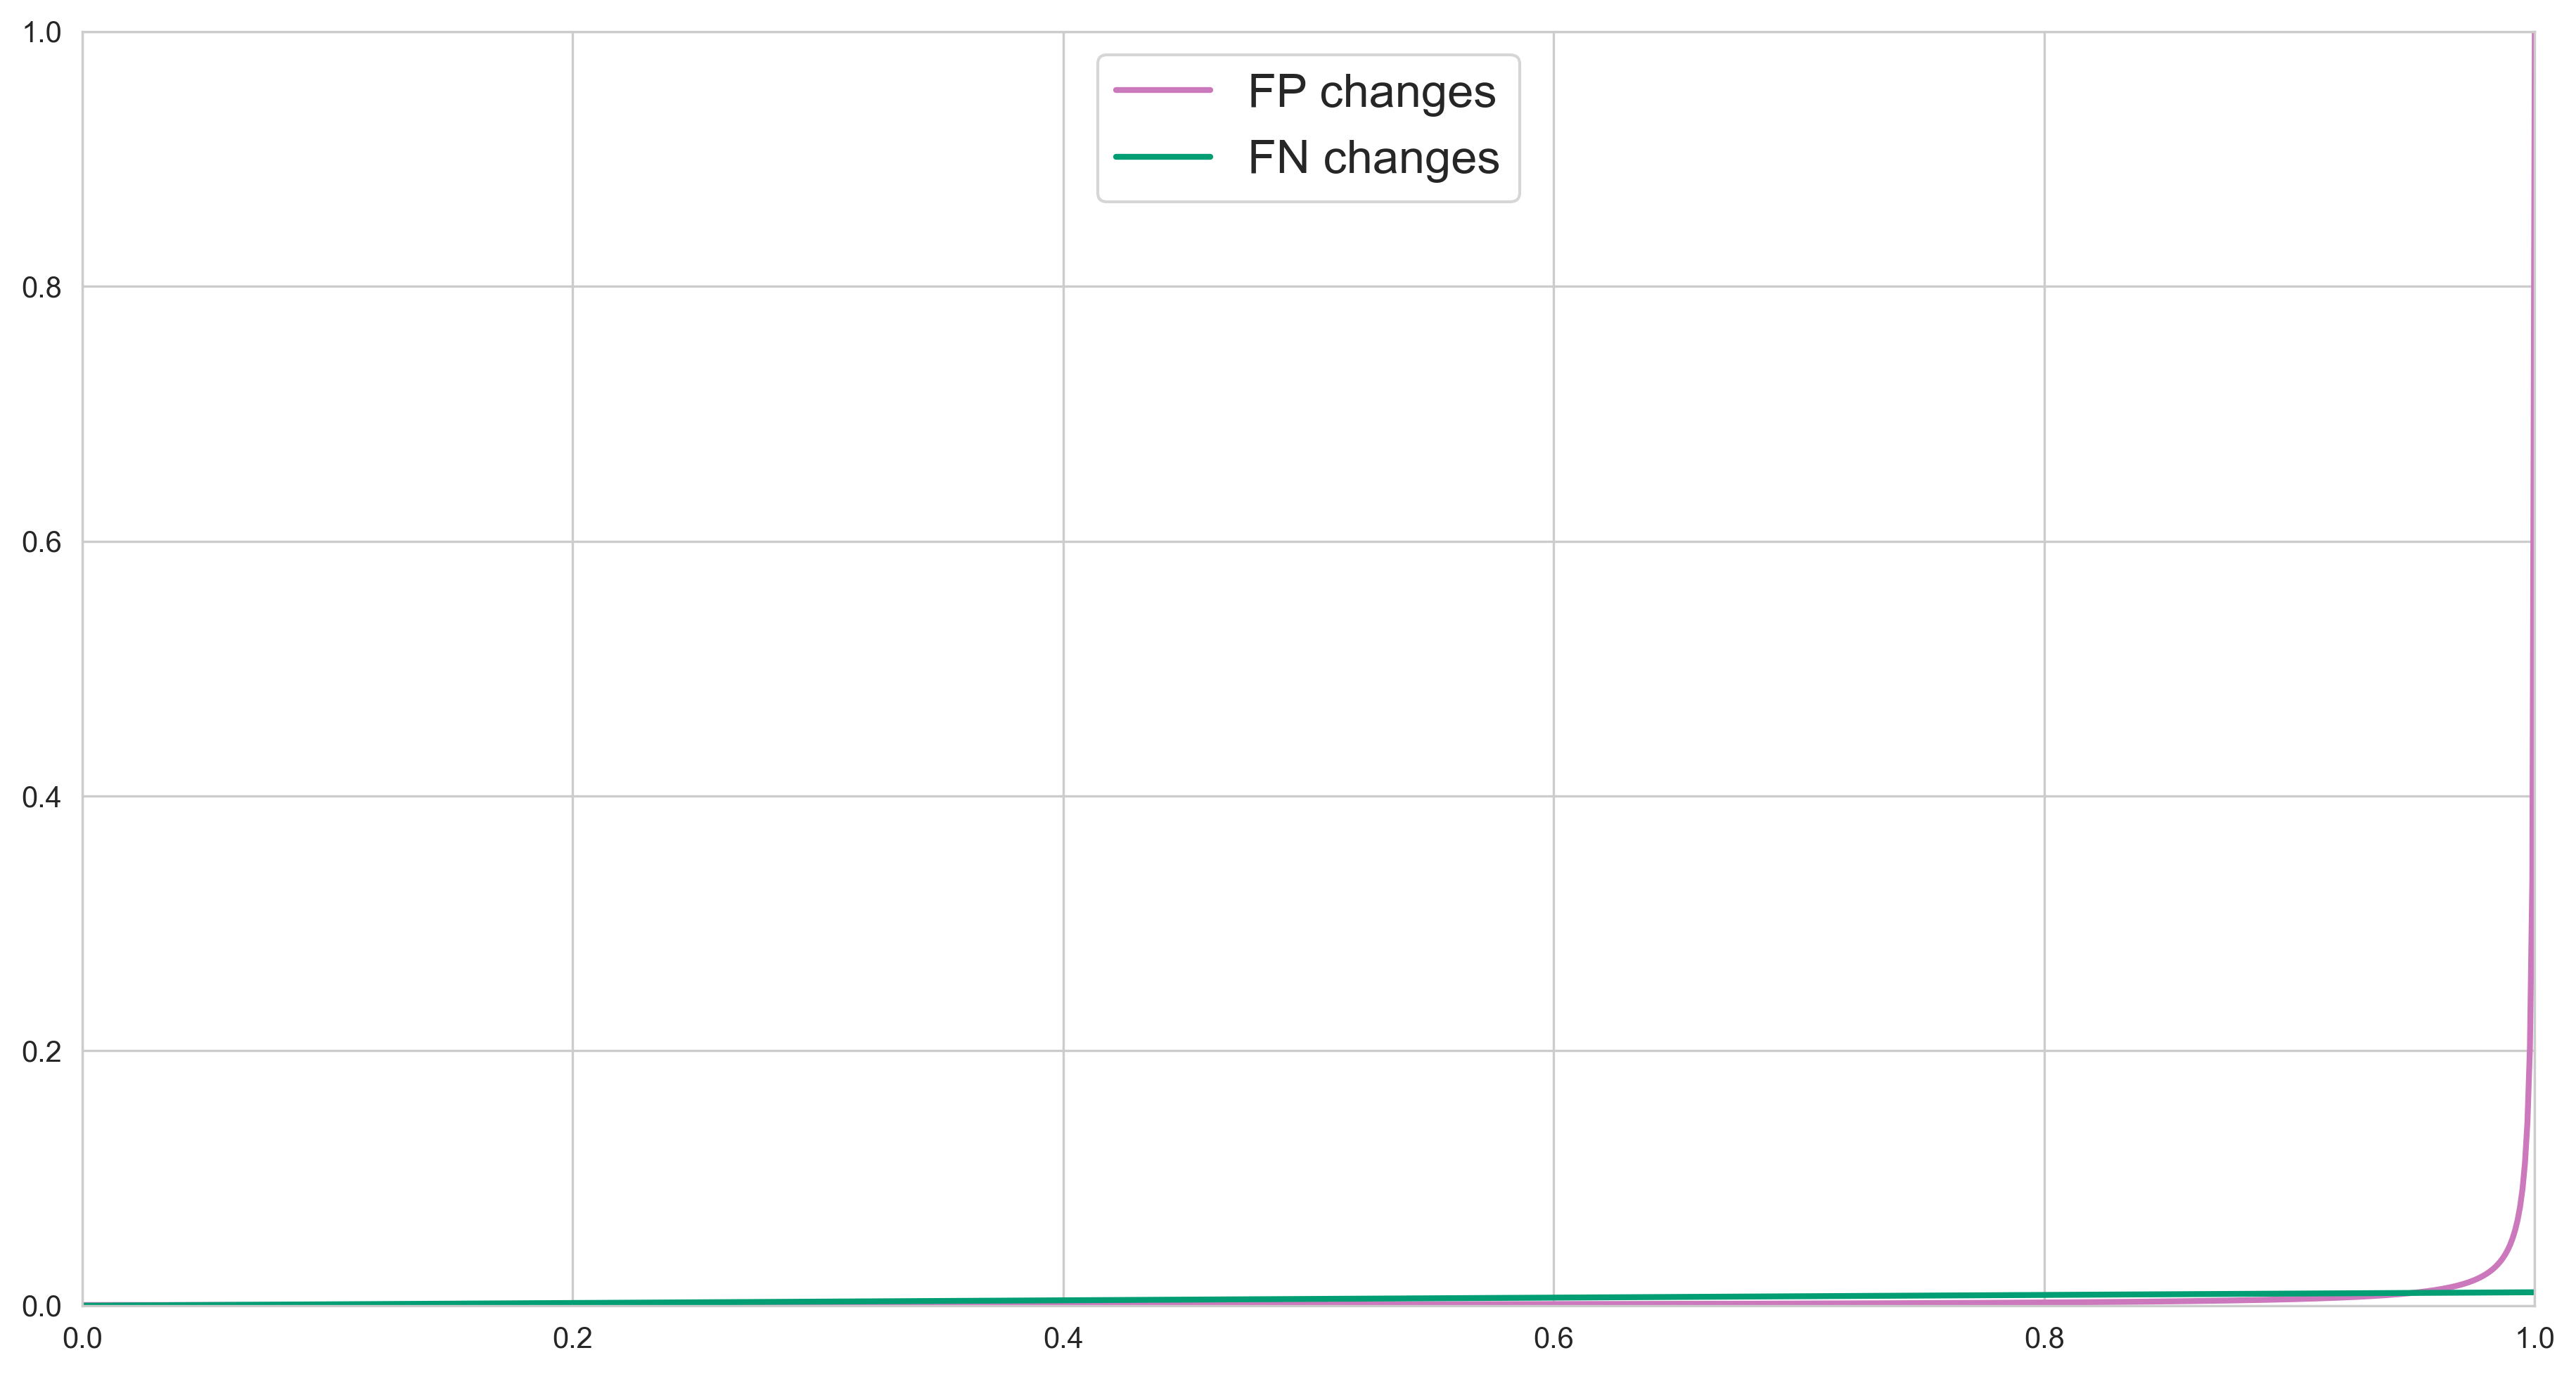

In [3]:
def curve_1(x = 0.05, y = 0.05):
    return (0.01 * (1 - y)) / (0.99 * x + 0.01 * (1 - y))

def curve_2(x = 0.05, y = 0.05):
    return (0.01 * y) / (0.99 * (1 - x) + 0.01 * y)
    
show_probability_plot(curve_1)
show_probability_plot(curve_2)

In [4]:
print("Если false positive = {:.2f}, то P(d=1|t=1) = {:.4f}".format(0.05, curve_1(x=0.05)))
print("Если false positive = {:.2f}, то P(d=1|t=1) = {:.4f}".format(0.03, curve_1(x=0.03)))
print("Если false positive = {:.2f}, то P(d=1|t=1) = {:.4f}".format(0.01, curve_1(x=0.01)))
print("Если false positive = {:.2f}, то P(d=1|t=1) = {:.4f}".format(0.00, curve_1(x=0.00)))

Если false positive = 0.05, то P(d=1|t=1) = 0.1610
Если false positive = 0.03, то P(d=1|t=1) = 0.2423
Если false positive = 0.01, то P(d=1|t=1) = 0.4897
Если false positive = 0.00, то P(d=1|t=1) = 1.0000


In [5]:
print("Если false negative = {:.2f}, то P(d=1|t=1) = {:.4f}".format(0.05, curve_1(y=0.05)))
print("Если false negative = {:.2f}, то P(d=1|t=1) = {:.4f}".format(0.03, curve_1(y=0.03)))
print("Если false negative = {:.2f}, то P(d=1|t=1) = {:.4f}".format(0.01, curve_1(y=0.01)))
print("Если false negative = {:.2f}, то P(d=1|t=1) = {:.4f}".format(0.00, curve_1(y=0.00)))

Если false negative = 0.05, то P(d=1|t=1) = 0.1610
Если false negative = 0.03, то P(d=1|t=1) = 0.1639
Если false negative = 0.01, то P(d=1|t=1) = 0.1667
Если false negative = 0.00, то P(d=1|t=1) = 0.1681


In [6]:
print("Если false positive = {:.2f}, то P(d=1|t=0) = {:.6f}".format(0.05, curve_2(x=0.05)))
print("Если false positive = {:.2f}, то P(d=1|t=0) = {:.6f}".format(0.03, curve_2(x=0.03)))
print("Если false positive = {:.2f}, то P(d=1|t=0) = {:.6f}".format(0.01, curve_2(x=0.01)))
print("Если false positive = {:.2f}, то P(d=1|t=0) = {:.6f}".format(0.00, curve_2(x=0.00)))

Если false positive = 0.05, то P(d=1|t=0) = 0.000531
Если false positive = 0.03, то P(d=1|t=0) = 0.000520
Если false positive = 0.01, то P(d=1|t=0) = 0.000510
Если false positive = 0.00, то P(d=1|t=0) = 0.000505


In [7]:
print("Если false negative = {:.2f}, то P(d=1|t=0) = {:.4f}".format(0.05, curve_2(y=0.05)))
print("Если false negative = {:.2f}, то P(d=1|t=0) = {:.4f}".format(0.03, curve_2(y=0.03)))
print("Если false negative = {:.2f}, то P(d=1|t=0) = {:.4f}".format(0.01, curve_2(y=0.01)))
print("Если false negative = {:.2f}, то P(d=1|t=0) = {:.4f}".format(0.00, curve_2(y=0.00)))

Если false negative = 0.05, то P(d=1|t=0) = 0.0005
Если false negative = 0.03, то P(d=1|t=0) = 0.0003
Если false negative = 0.01, то P(d=1|t=0) = 0.0001
Если false negative = 0.00, то P(d=1|t=0) = 0.0000


Исходя из вышеизложенного, ученым лучше сосредоточиться на улучшении ошибки false positive, так как по сравнению с false negative - это дает значительный прирост в точности $P(d=1\mid{t=1})$.

## Часть II: О линейной регрессии

Эта часть первого домашнего задания связана с анализом конкретного датасета. Датасет давайте возьмём довольно релевантный реальной жизни; он доступен по следующей ссылке:

https://ourworldindata.org/coronavirus-source-data

### 1

Скачайте данные в формате csv, выберите из таблицы данные по России, начиная с 3 марта 2020 г. (в этот момент впервые стало больше 2 заболевших). В качестве целевой переменной возьмём число случаев заболевания (столбцы total_cases и new_cases); для упрощения обработки можно заменить в столбце new_cases все нули на единицы. Для единообразия давайте зафиксируем тренировочный набор в виде первых 50 отсчётов (дней), начиная с 3 марта; остальные данные можно использовать в качестве тестового набора (и он даже будет увеличиваться по мере выполнения задания). Иначе говоря, мы будем “играть” за российские власти, которые пытаются понять, что делать, глядя на данные об эпидемии в мае 2020 года.

In [8]:
data = pd.read_csv("owid-covid-data.csv")
data = data[data['iso_code'] == 'RUS']
data = data[data['date'] >= '2020-03-03']
data.loc[data['new_cases'] == 0, 'new_cases'] = 1
data_size = data.shape[0]

In [9]:
train_size = 50
train_data = data[:train_size]
test_data = data[train_size:]

In [10]:
train_data.reset_index(inplace=True)

### 2

Постройте графики целевых переменных. Вы увидите, что число заболевших растёт очень быстро, на первый взгляд экспоненциально. Для первого подхода к снаряду давайте это и используем.

### 2.a

Используя линейную регрессию, обучите модель с экспоненциальным ростом числа заболевших: y ~ exp(линейная функция от x), где x — номер текущего дня.

In [11]:
train_days = np.arange(train_size)
y_data = np.log(train_data['total_cases'])

In [12]:
lr = LinearRegression()
lr.fit(np.reshape(train_days, (-1, 1)), y_data)
coef = lr.coef_
intercept = lr.intercept_

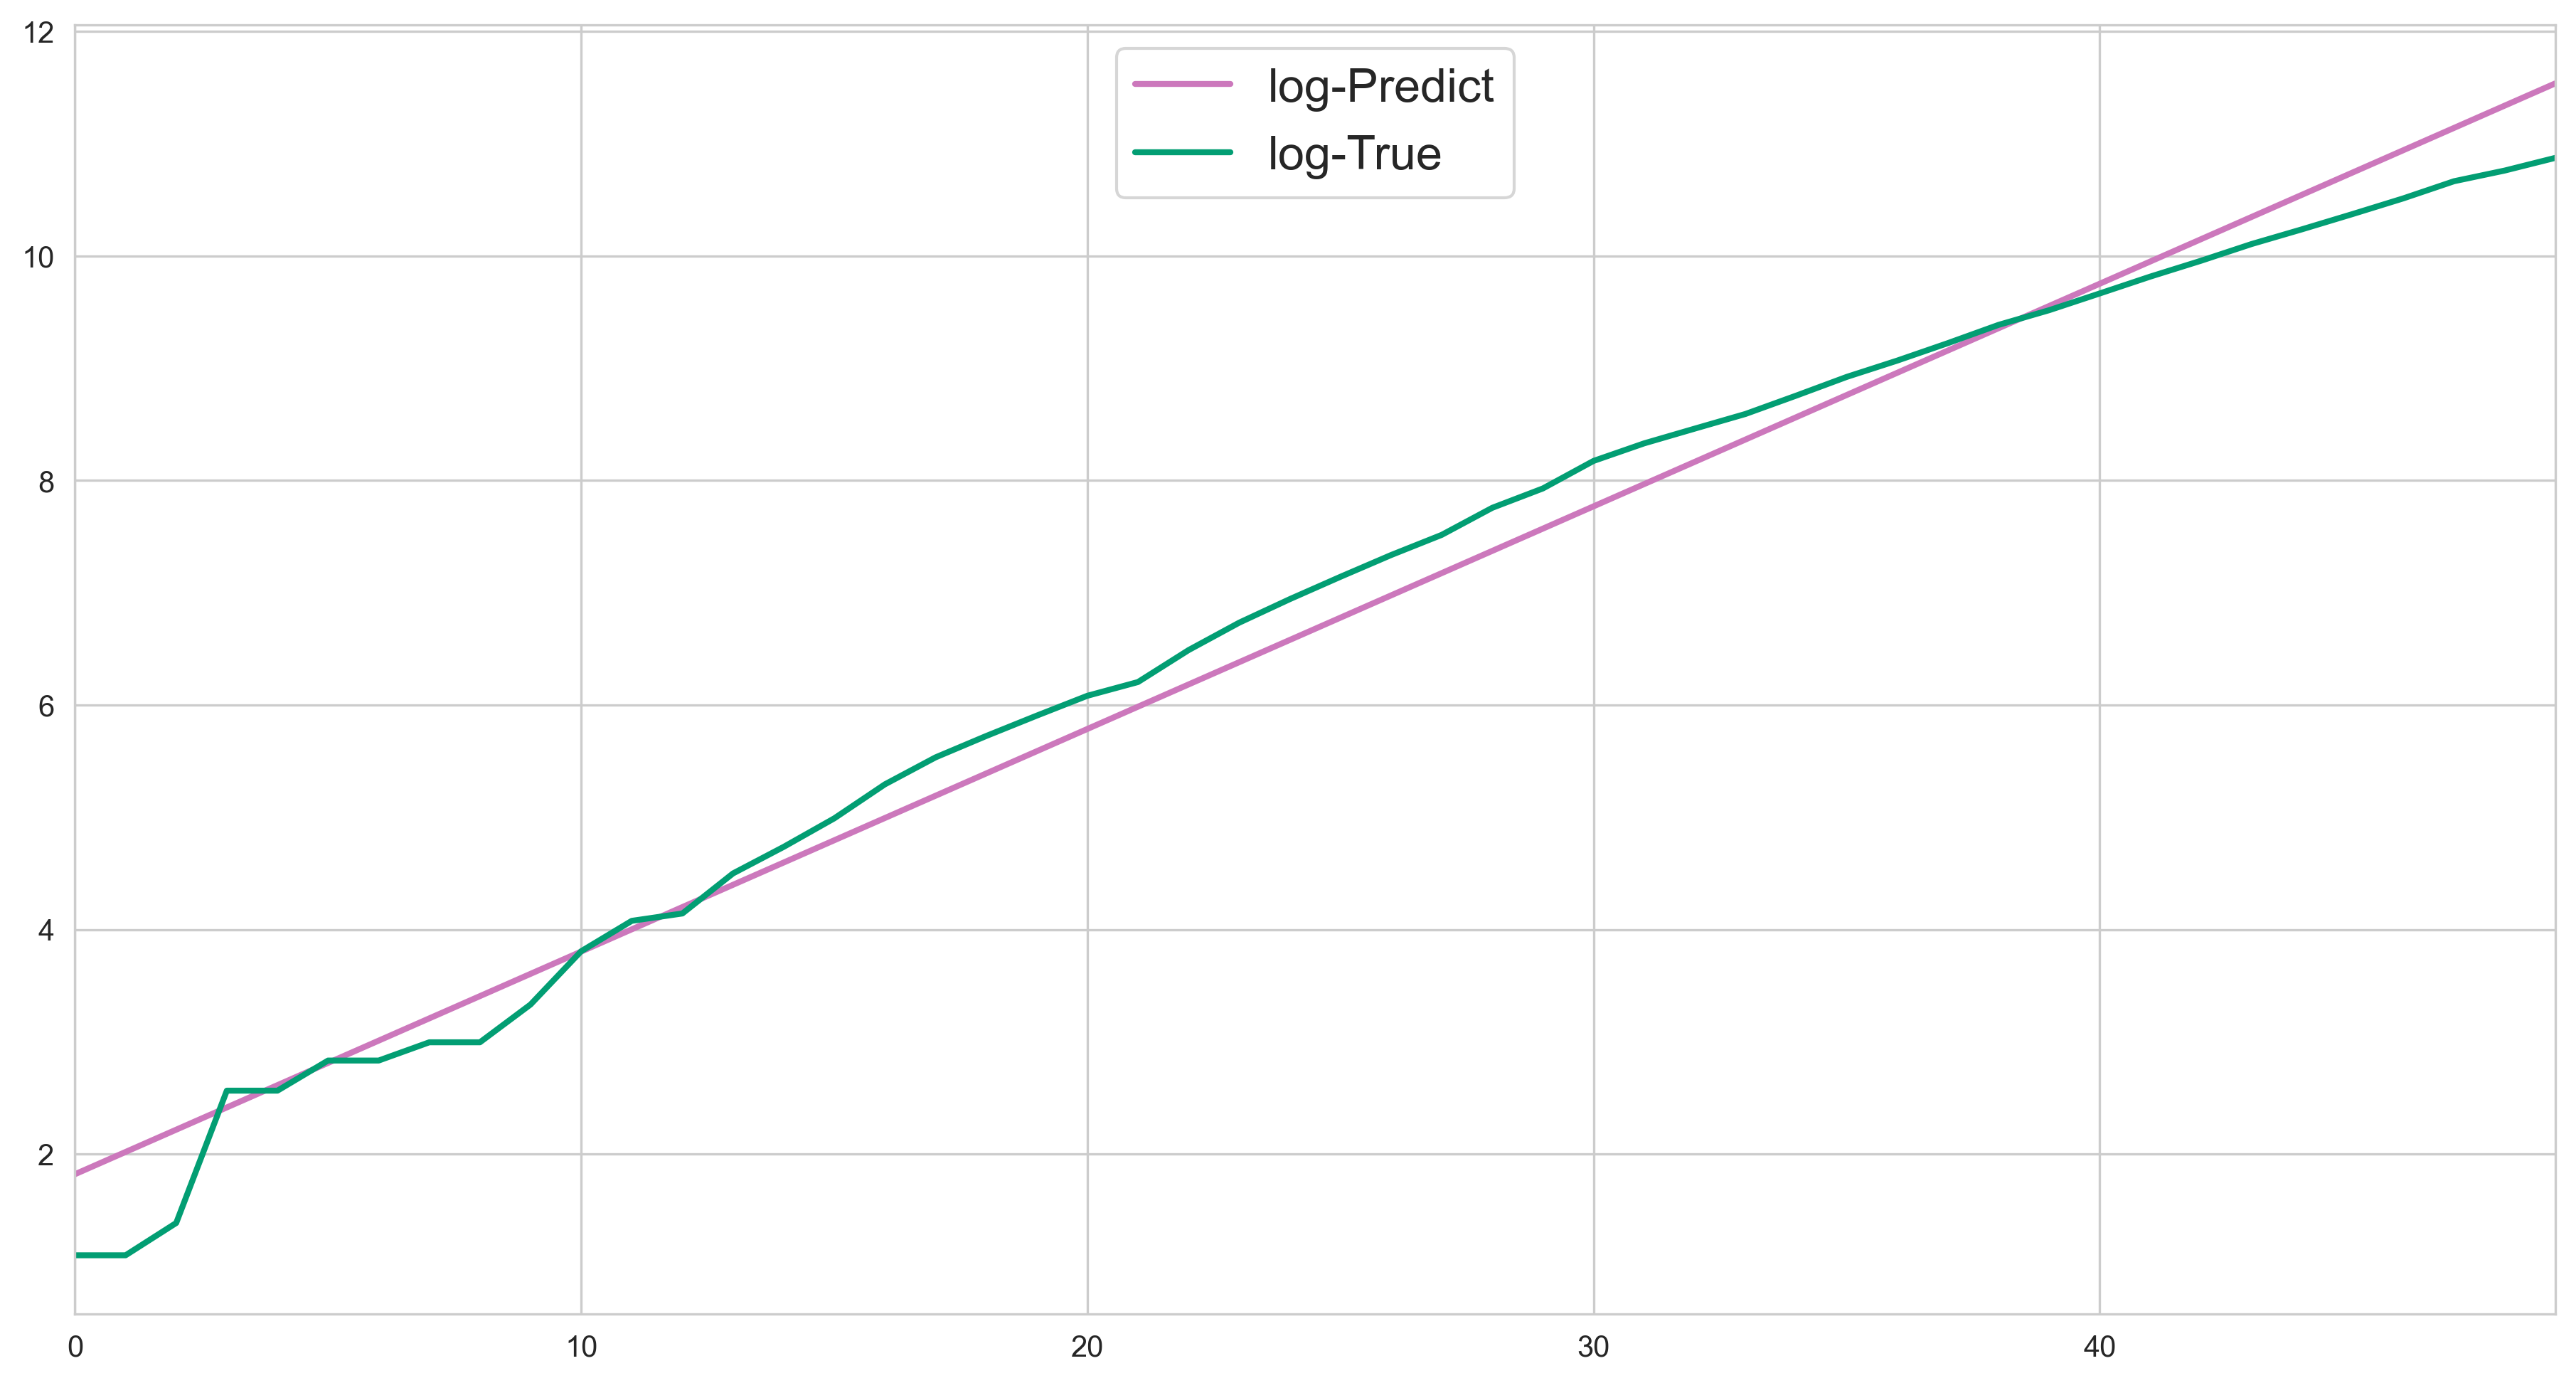

In [13]:
def true_curve(t, coef, intercept):
    return coef[0] * t + intercept

predict = true_curve(train_days, coef, intercept)

fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)
ax.set_xlim((train_days[0], train_days[-1]))

ax.plot(train_days, predict, linewidth=2, label="log-Predict", color=palette[4])
ax.plot(train_days, np.log(train_data['total_cases']), linewidth=2, label="log-True", color=palette[2])

ax.legend(loc="upper center", fontsize=legend_fontsize)
plt.show()

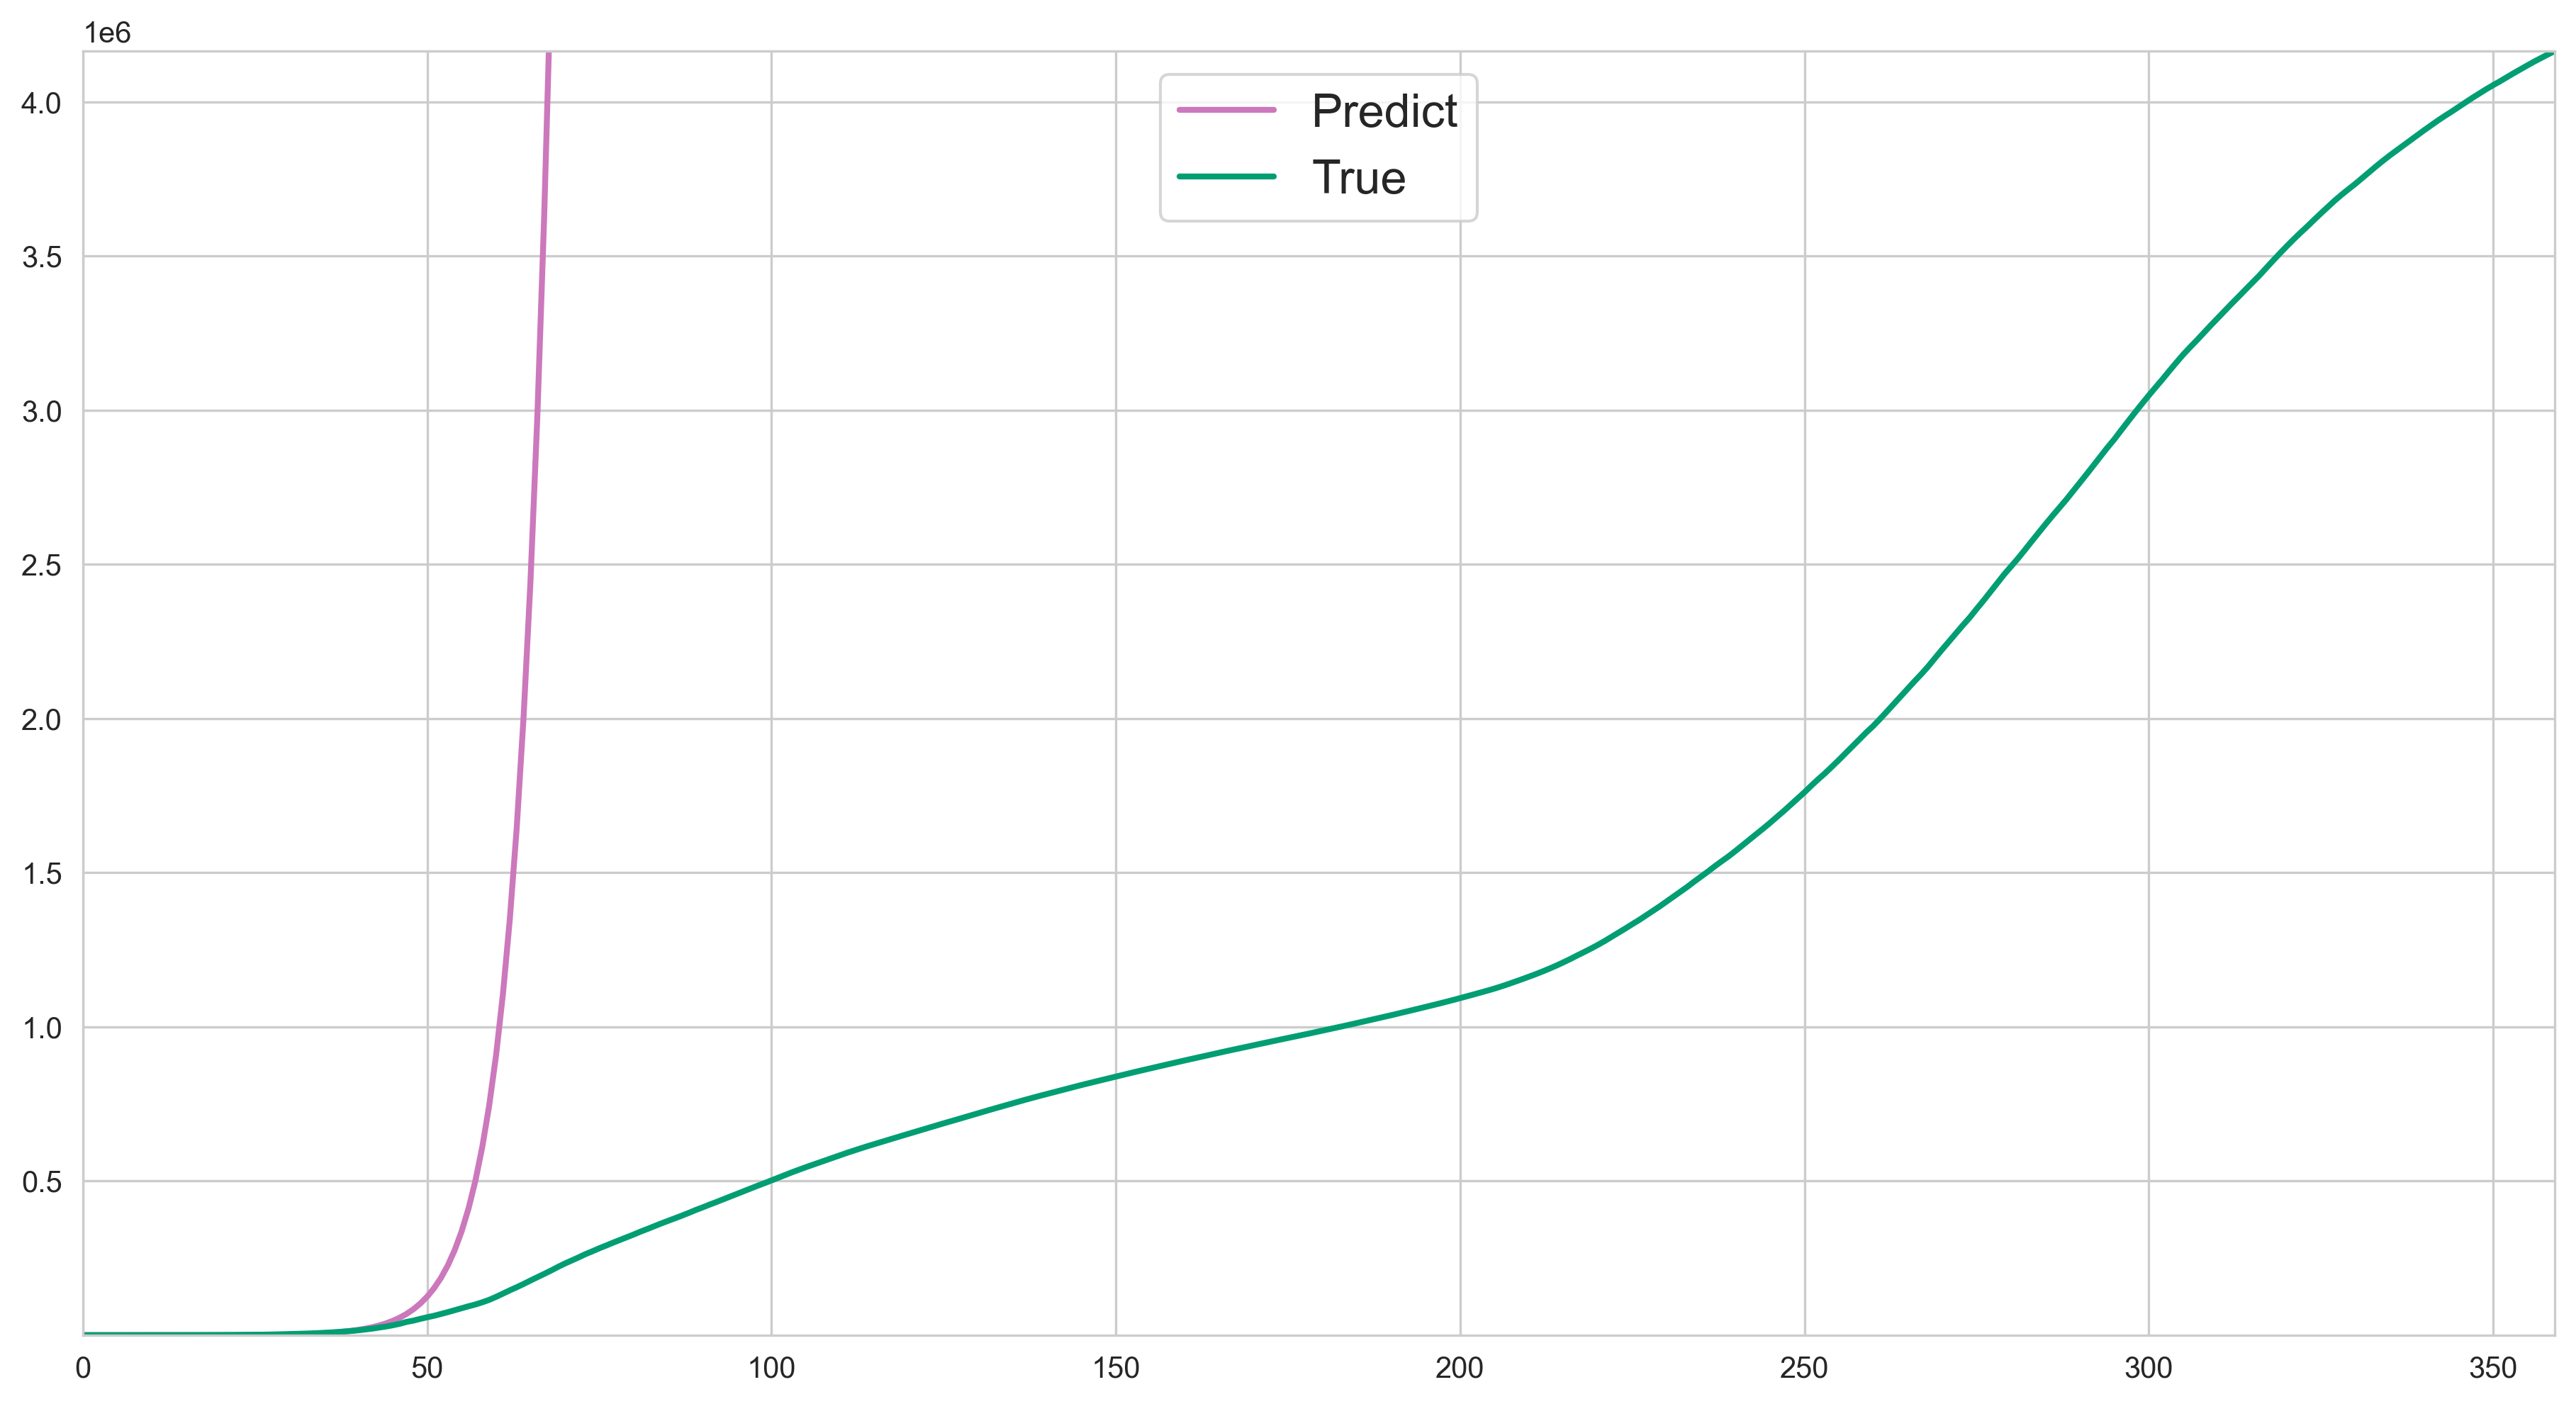

In [14]:
days = np.arange(data.shape[0])
predict = np.exp(true_curve(days, coef, intercept))

fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)
ax.set_xlim((days[0], days[-1]))
ax.set_ylim((data['total_cases'].iloc[0], data['total_cases'].iloc[-1]))

ax.plot(days, predict, linewidth=2, label="Predict", color=palette[4])
ax.plot(days, data['total_cases'], linewidth=2, label="True", color=palette[2])

ax.legend(loc="upper center", fontsize=legend_fontsize)
plt.show()

### 2.b

Найдите апостериорное распределение параметров этой модели для достаточно широкого априорного распределения. Требующееся для этого значение дисперсии шума в данных оцените, исходя из вашей же максимальной апостериорной модели (это фактически первый шаг эмпирического Байеса).

In [15]:
%%script false
def get_likelihood(px, py, sigma=.5):
    return lambda x : np.exp(-(x[0] + x[1] * px - py) ** 2) / (2 * sigma * np.sqrt(2. * np.pi))

Couldn't find program: 'false'


In [16]:
def bayesian_update(mu, sigma, x, y, sigma_noise):
    x_matrix = np.array([[1, x]])
    sigma_n = np.linalg.inv(np.linalg.inv(sigma) + (1 / (sigma_noise ** 2)) * np.matmul(np.transpose(x_matrix), x_matrix) )
    mu_n = np.matmul(sigma_n, np.matmul(np.linalg.inv(sigma), np.transpose(mu)) + (1 / (sigma_noise ** 2)) * np.matmul(np.transpose(x_matrix), np.array([y])))
    return mu_n, sigma_n

In [17]:
def sample_statistics(mu, sigma, xs, n=20):
    my_w = np.random.multivariate_normal(mu, sigma, n)
    res = np.zeros((n, xs.shape[0]))
    for i,w in enumerate(my_w):
        res[i, :] = w[0] + w[1] * xs
    return res

In [18]:
def plot_predictions(xs, mu, x, points, sigma_noise):
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111)
    ax.set_xlim((xs[0], xs[-1]))
    ax.plot(xs, mu[1] * xs + mu[0], color="red", label="MAP гипотеза")
    ax.fill_between(xs, mu[1] * xs + mu[0] - sigma_noise, mu[1] * xs + mu[0] + sigma_noise, color=palette[1], alpha=.3, label="+- дисперсия шума")
    ax.fill_between(xs, np.mean(x, axis=0) - np.std(x, axis=0), np.mean(x, axis=0) + np.std(x, axis=0), color=palette[5], alpha=.2, label="+- дисперсия предсказаний")
    ax.scatter(points[0], points[1], marker='*', s=200)
    ax.legend(fontsize=legend_fontsize)

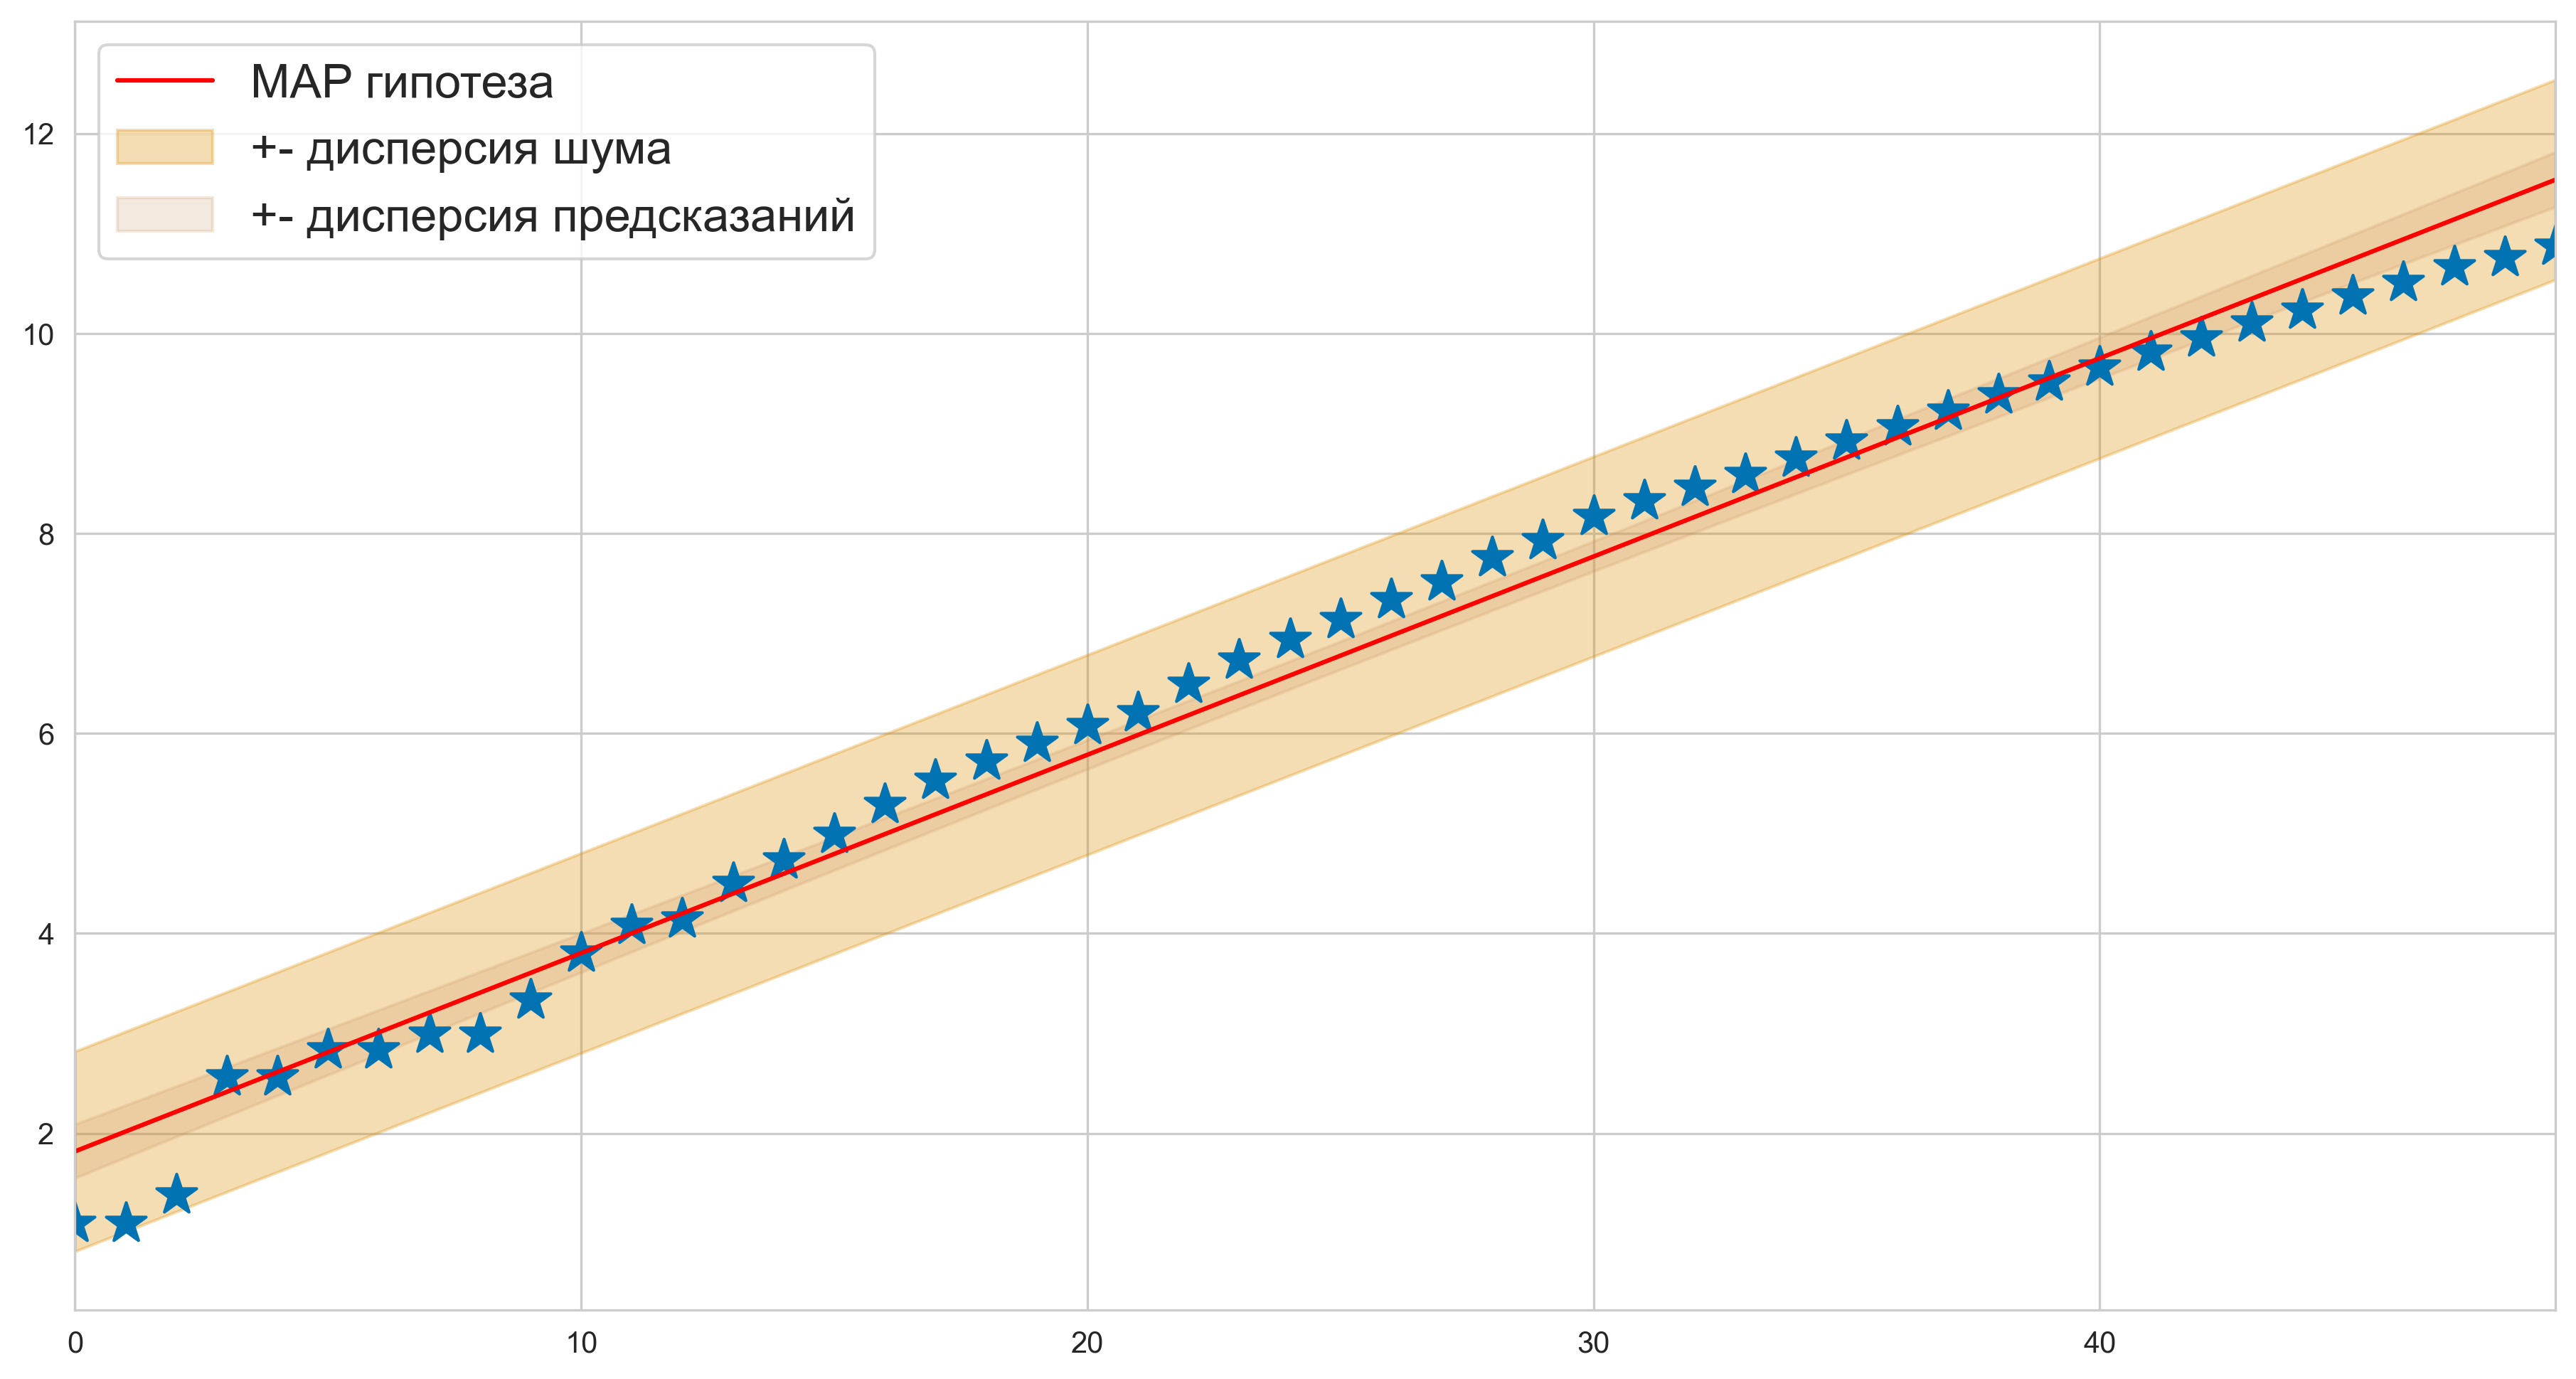

In [19]:
cur_mu, cur_sigma = np.array([0, 0]), 100 * np.array([[1, 0], [0, 1]])
lam = 0.01
sigma_noise = lam * 100

px = []
py = []

for i in range(train_size):
    px.append(train_days[i])
    py.append(np.log(train_data['total_cases'][i]))
    #cur_likelihood = get_likelihood(px[-1], py[-1])
    cur_mu, cur_sigma = bayesian_update(cur_mu, cur_sigma, px[-1], py[-1], sigma_noise)    
x = sample_statistics(cur_mu, cur_sigma, train_days, n=2000)
plot_predictions(train_days, cur_mu, x, [px, py], sigma_noise)
plt.show()

In [20]:
def sample_statistics_exp(mu, sigma, xs, n=20):
    my_w = np.random.multivariate_normal(mu, sigma, n)
    res = np.zeros((n, xs.shape[0]))
    for i,w in enumerate(my_w):
        res[i, :] = np.exp(w[0] + w[1] * xs)
    return res

In [21]:
def plot_predictions_exp(xs, mu, x, points, sigma_noise):
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111)
    ax.set_xlim((xs[0], xs[-1]))
    ax.plot(xs, np.exp(mu[1] * xs + mu[0]), color="red", label="MAP гипотеза")
    ax.fill_between(xs, np.exp(mu[1] * xs + mu[0] - sigma_noise), np.exp(mu[1] * xs + mu[0] + sigma_noise), color=palette[1], alpha=.3, label="+- дисперсия шума")
    ax.fill_between(xs, np.mean(x, axis=0) - np.std(x, axis=0), np.mean(x, axis=0) + np.std(x, axis=0), color=palette[5], alpha=.2, label="+- дисперсия предсказаний")
    ax.scatter(points[0], np.exp(points[1]), marker='*', s=200)
    ax.legend(fontsize=legend_fontsize)

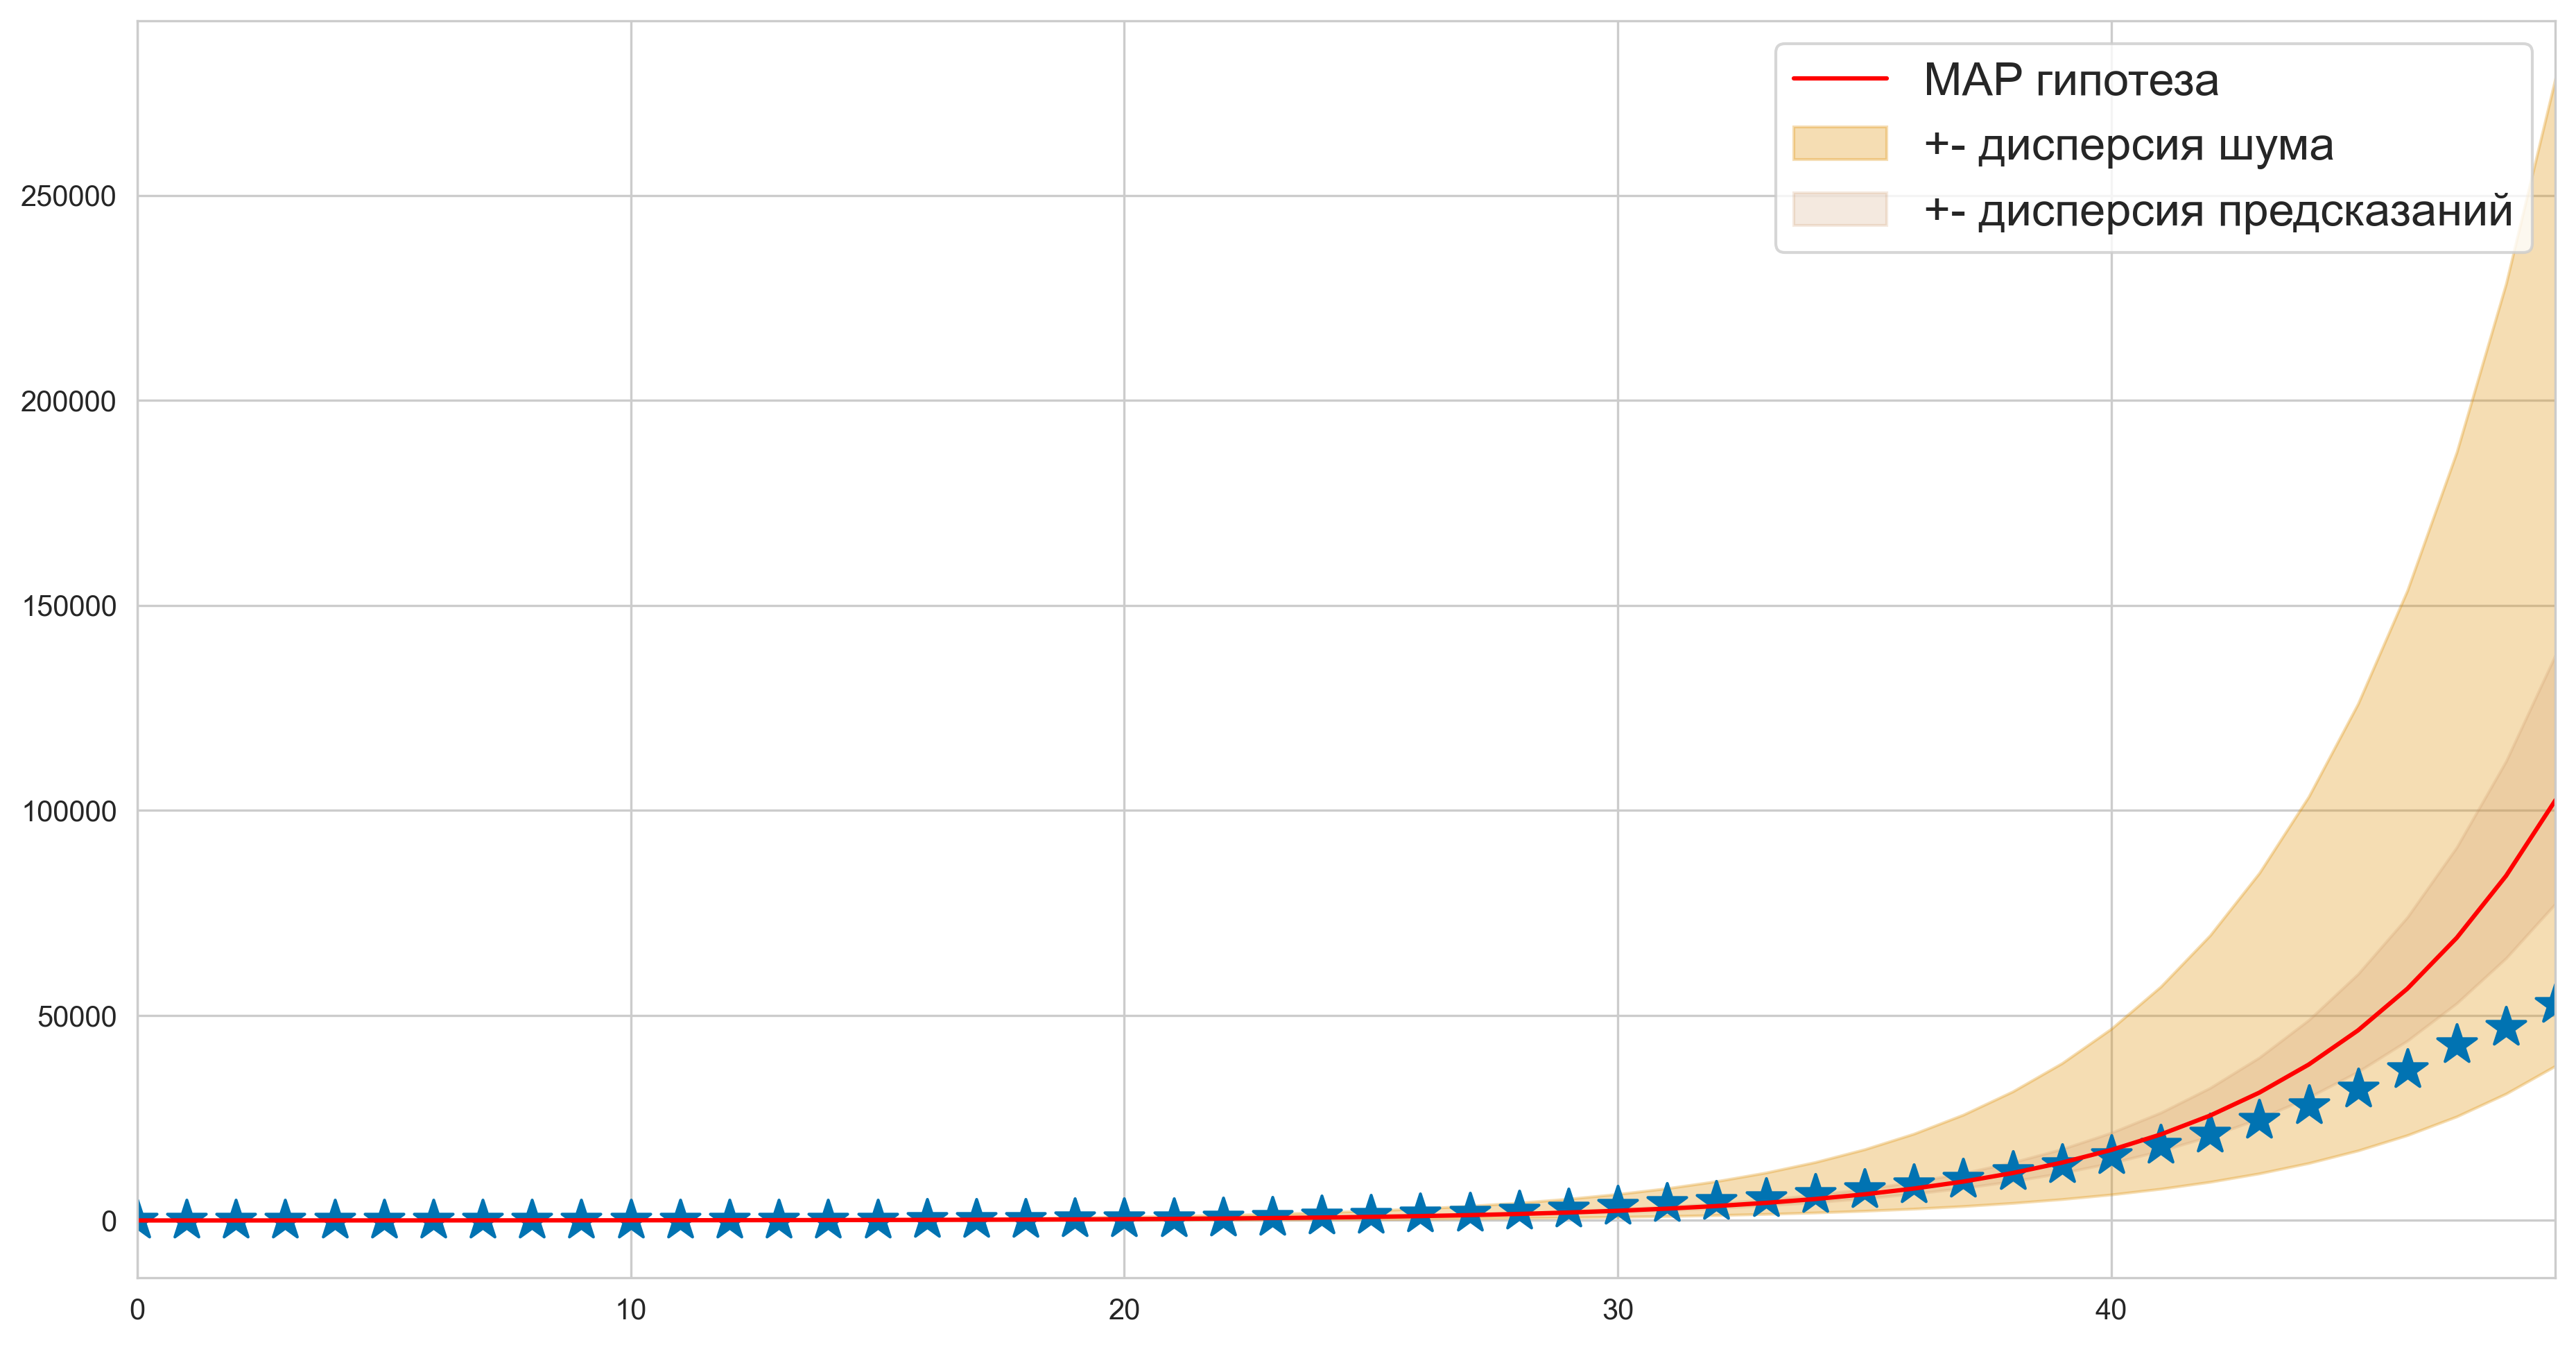

In [22]:
x = sample_statistics_exp(cur_mu, cur_sigma, train_days, n=2000)
plot_predictions_exp(train_days, cur_mu, x, [px, py], sigma_noise)
plt.show()

### 2.c

Посэмплируйте много разных экспонент, постройте графики. Сколько, исходя из этих сэмплов, предсказывается случаев коронавируса в России к 1 мая 2020 года? к 1 июня? к 1 сентября? Постройте предсказательные распределения (можно эмпирически, исходя из данных сэмплирования).

In [23]:
def plot_predictions_exp_total(xs, mu, x, points, sigma_noise):
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111)
    ax.set_xlim((xs[0], xs[-1]))
    ax.set_ylim((0, 1e7))
    ax.plot(xs, np.exp(mu[1] * xs + mu[0]), color="red", label="MAP гипотеза")
    ax.fill_between(xs, np.exp(mu[1] * xs + mu[0] - sigma_noise), np.exp(mu[1] * xs + mu[0] + sigma_noise), color=palette[1], alpha=.3, label="+- дисперсия шума")
    ax.fill_between(xs, np.mean(x, axis=0) - np.std(x, axis=0), np.mean(x, axis=0) + np.std(x, axis=0), color=palette[5], alpha=.2, label="+- дисперсия предсказаний")
    ax.legend(fontsize=legend_fontsize)

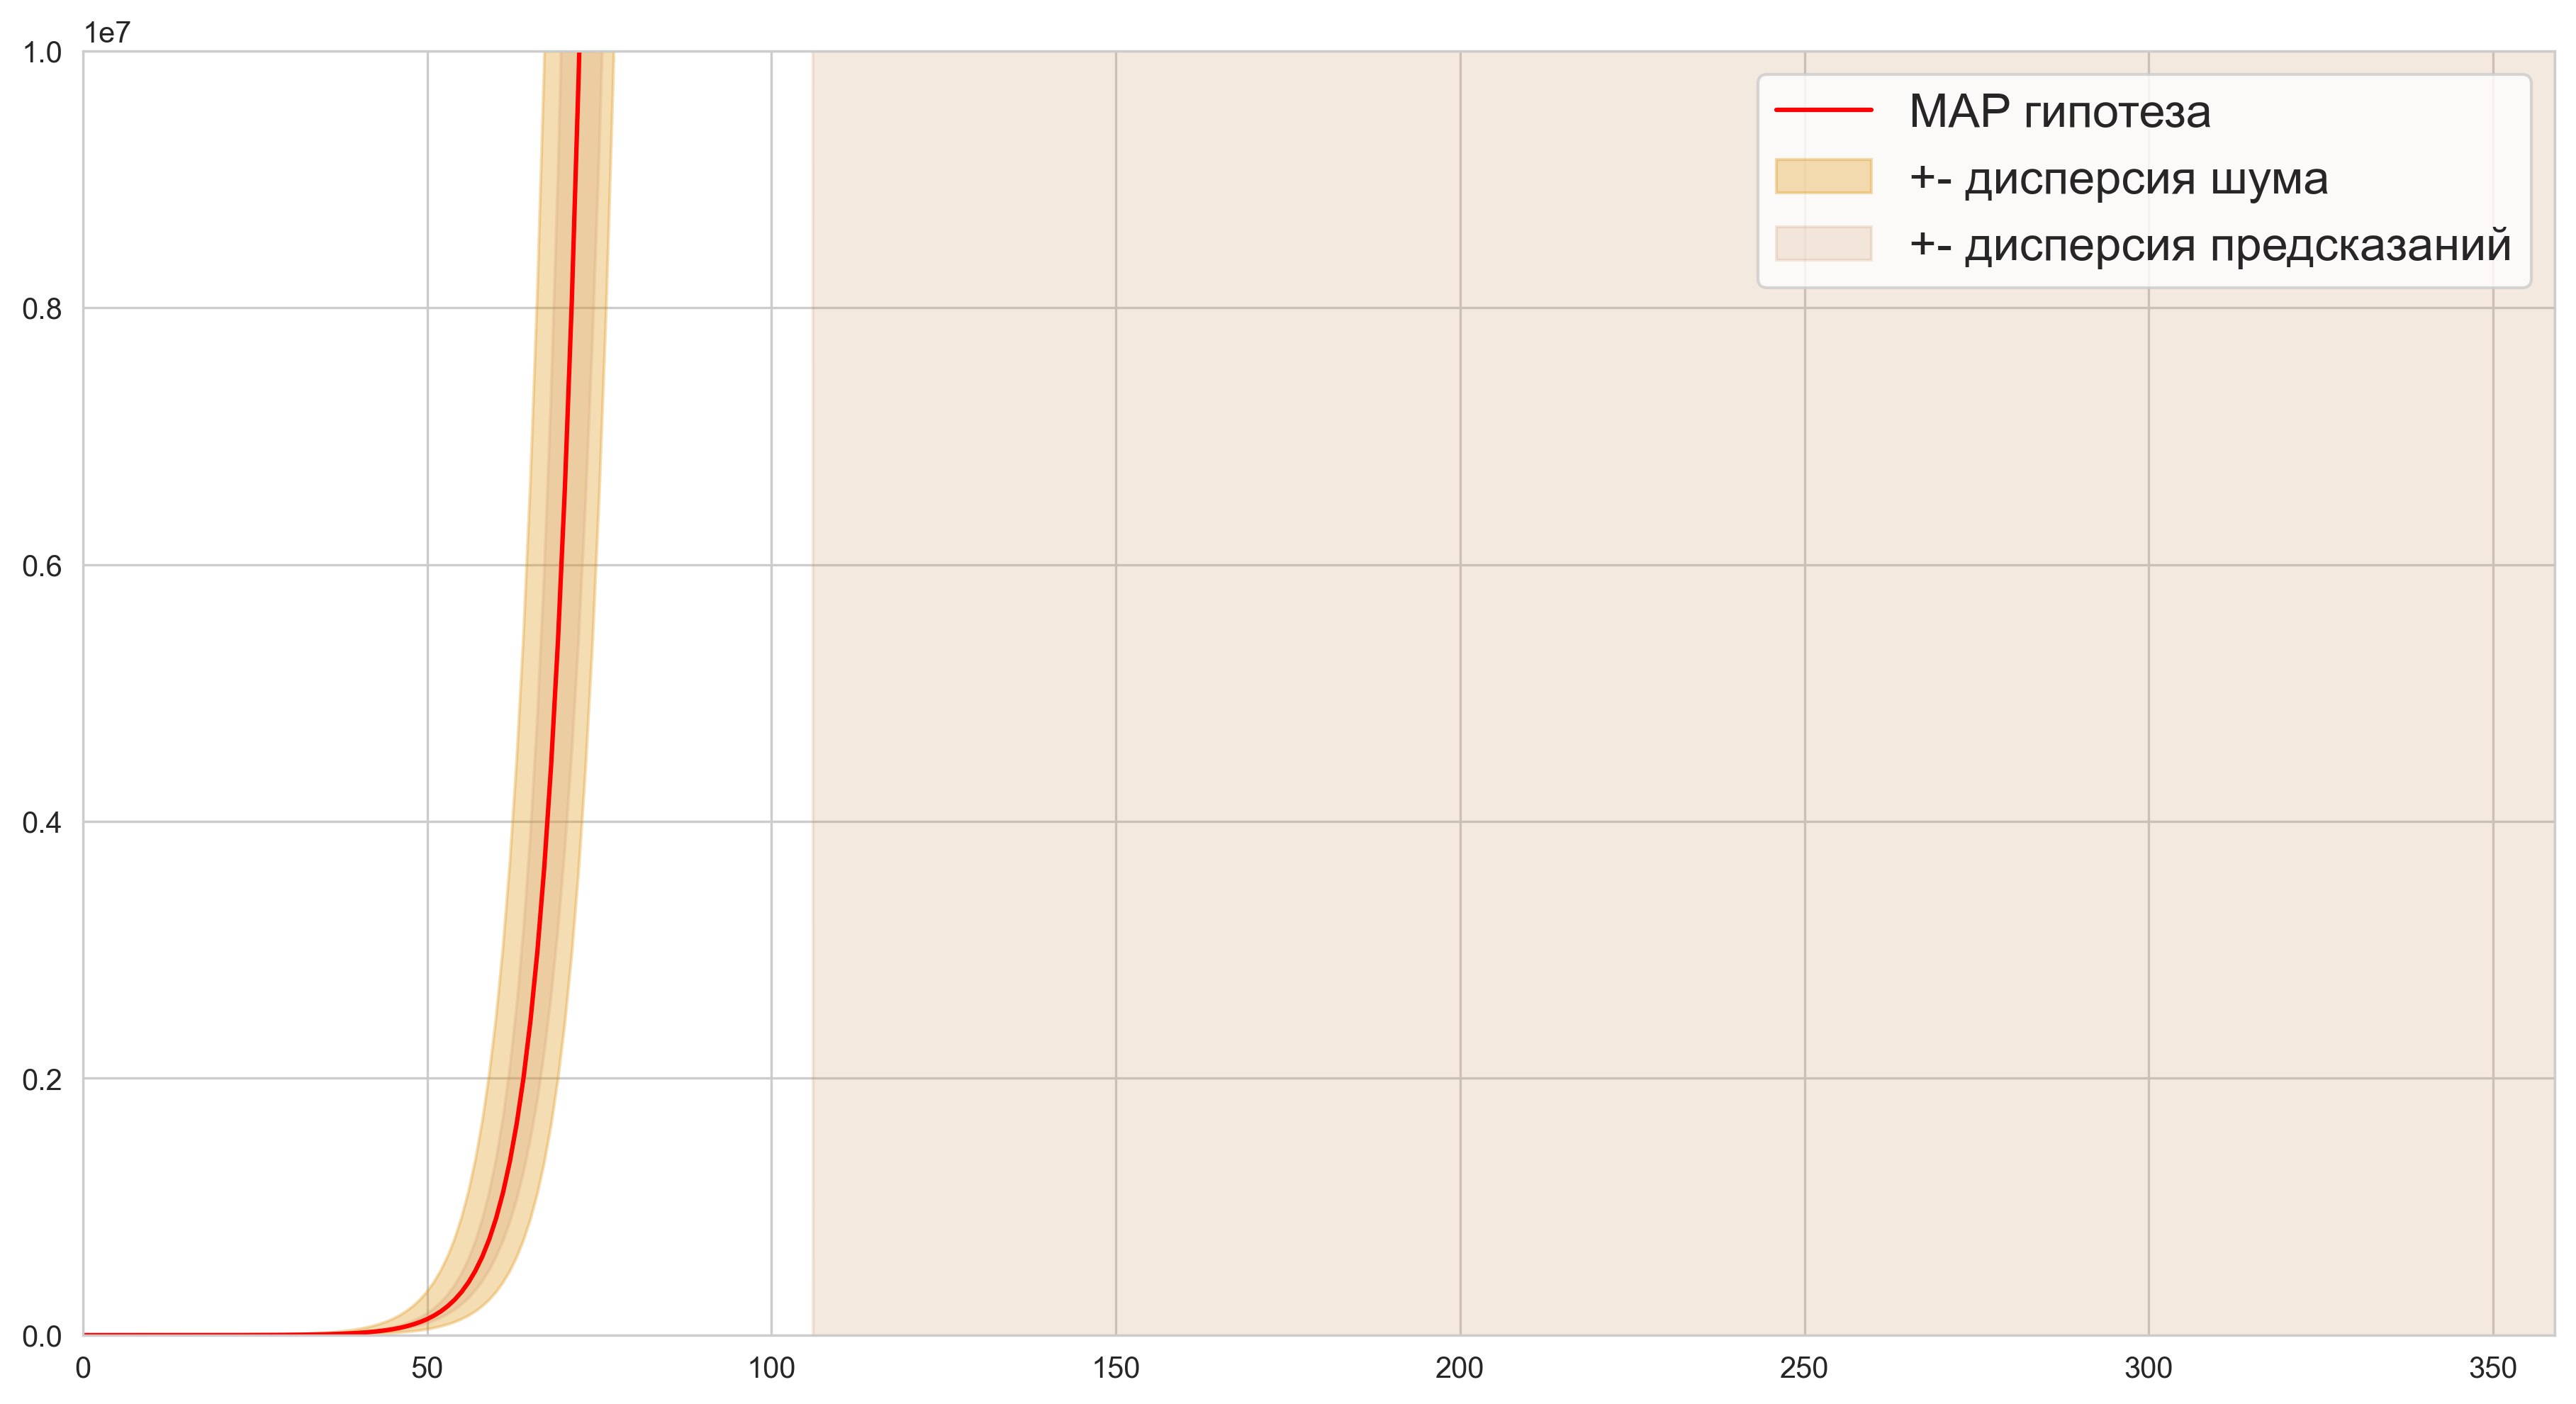

In [24]:
sample_count = 2000
x = sample_statistics_exp(cur_mu, cur_sigma, days, n=sample_count)
plot_predictions_exp_total(days, cur_mu, x, [days, data['total_cases']], sigma_noise)
plt.show()

In [25]:
result = np.exp(cur_mu[1] * days + cur_mu[0])

In [26]:
day_march = date(2020, 3, 3)
day_may = date(2020, 5, 1)
day_june = date(2020, 6, 1)
day_september = date(2020, 9, 1)

In [27]:
delta_may = (day_may - day_march).days
delta_june = (day_june - day_march).days
delta_september = (day_september - day_march).days

In [28]:
print("Предсказано {:.4e} случаев заражения коронавирусом в России на {}.".format(round(result[delta_may]), day_may))
print("Предсказано {:.4e} случаев заражения коронавирусом в России на {}.".format(round(result[delta_june]), day_june))
print("Предсказано {:.4e} случаев заражения коронавирусом в России на {}.".format(round(result[delta_september]), day_september))

Предсказано 7.4490e+05 случаев заражения коронавирусом в России на 2020-05-01.
Предсказано 3.4857e+08 случаев заражения коронавирусом в России на 2020-06-01.
Предсказано 2.9290e+16 случаев заражения коронавирусом в России на 2020-09-01.


In [29]:
data_may = []
data_june = []
data_september = []
for i in range(sample_count):
    data_may.append(x[i][delta_may])
    data_june.append(x[i][delta_june])
    data_september.append(x[i][delta_september])

array([[<AxesSubplot:title={'center':'May'}>]], dtype=object)

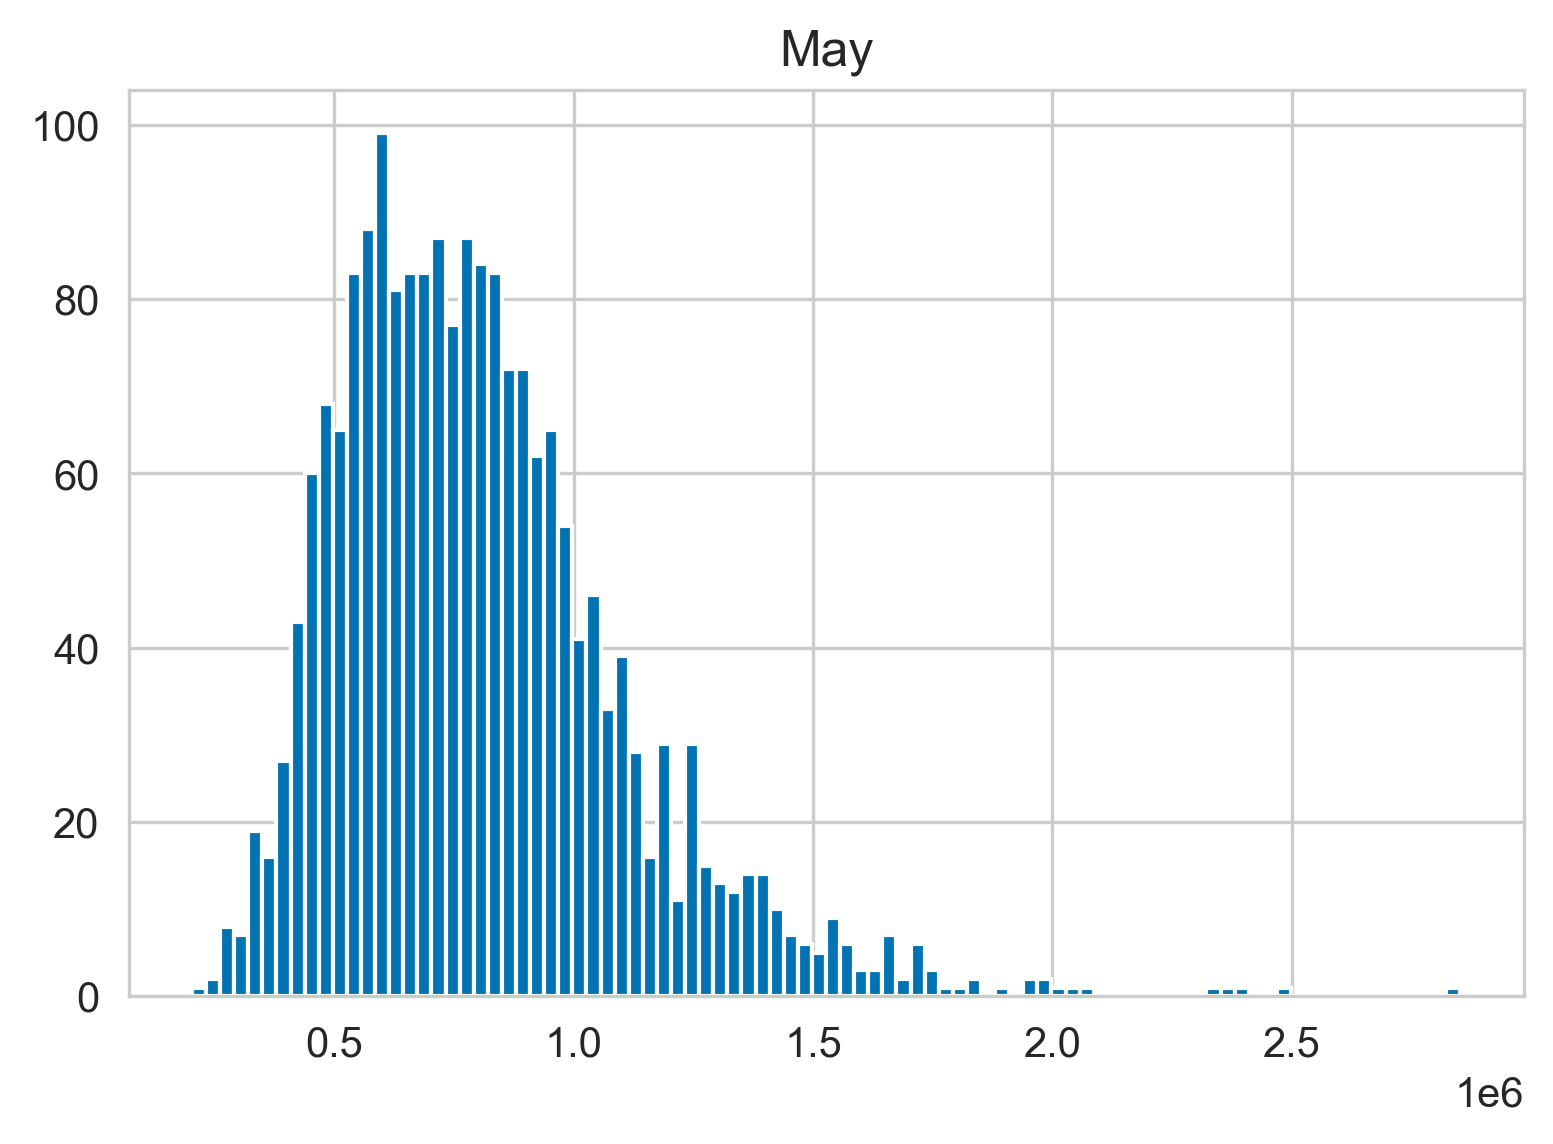

In [30]:
pd.DataFrame(data_may, columns=["May"]).hist(bins = 90)

array([[<AxesSubplot:title={'center':'June'}>]], dtype=object)

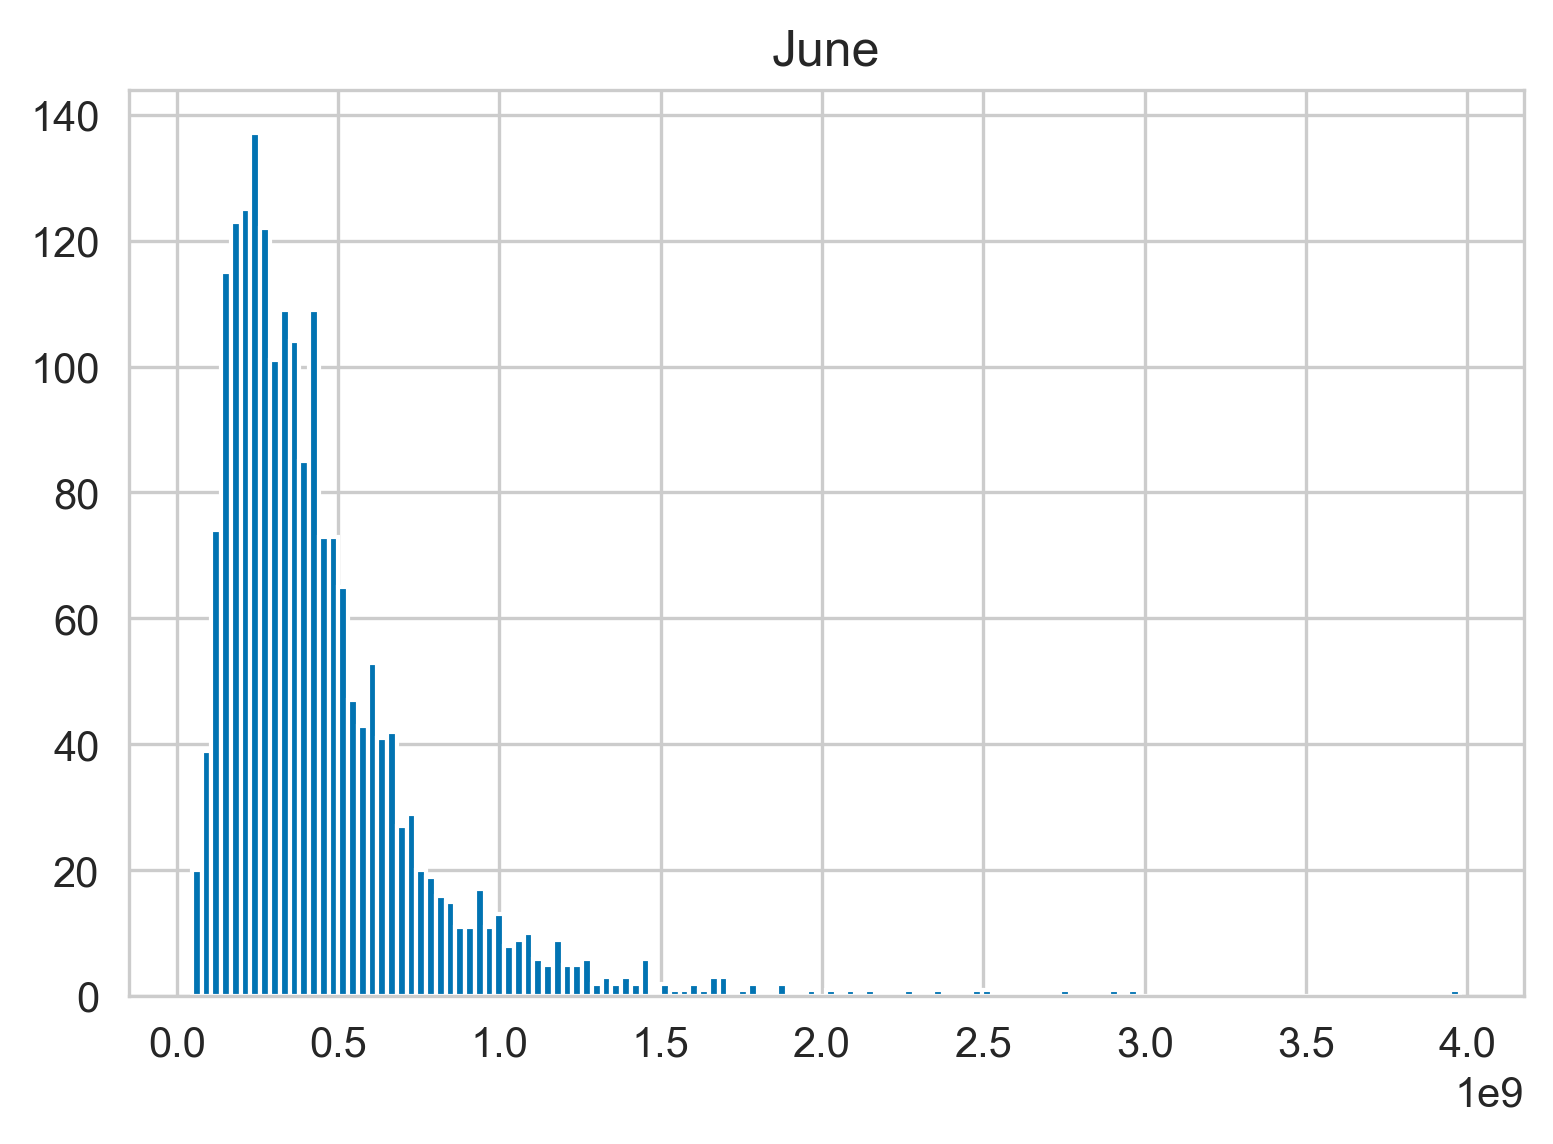

In [31]:
pd.DataFrame(data_june, columns=["June"]).hist(bins = 130)

array([[<AxesSubplot:title={'center':'September'}>]], dtype=object)

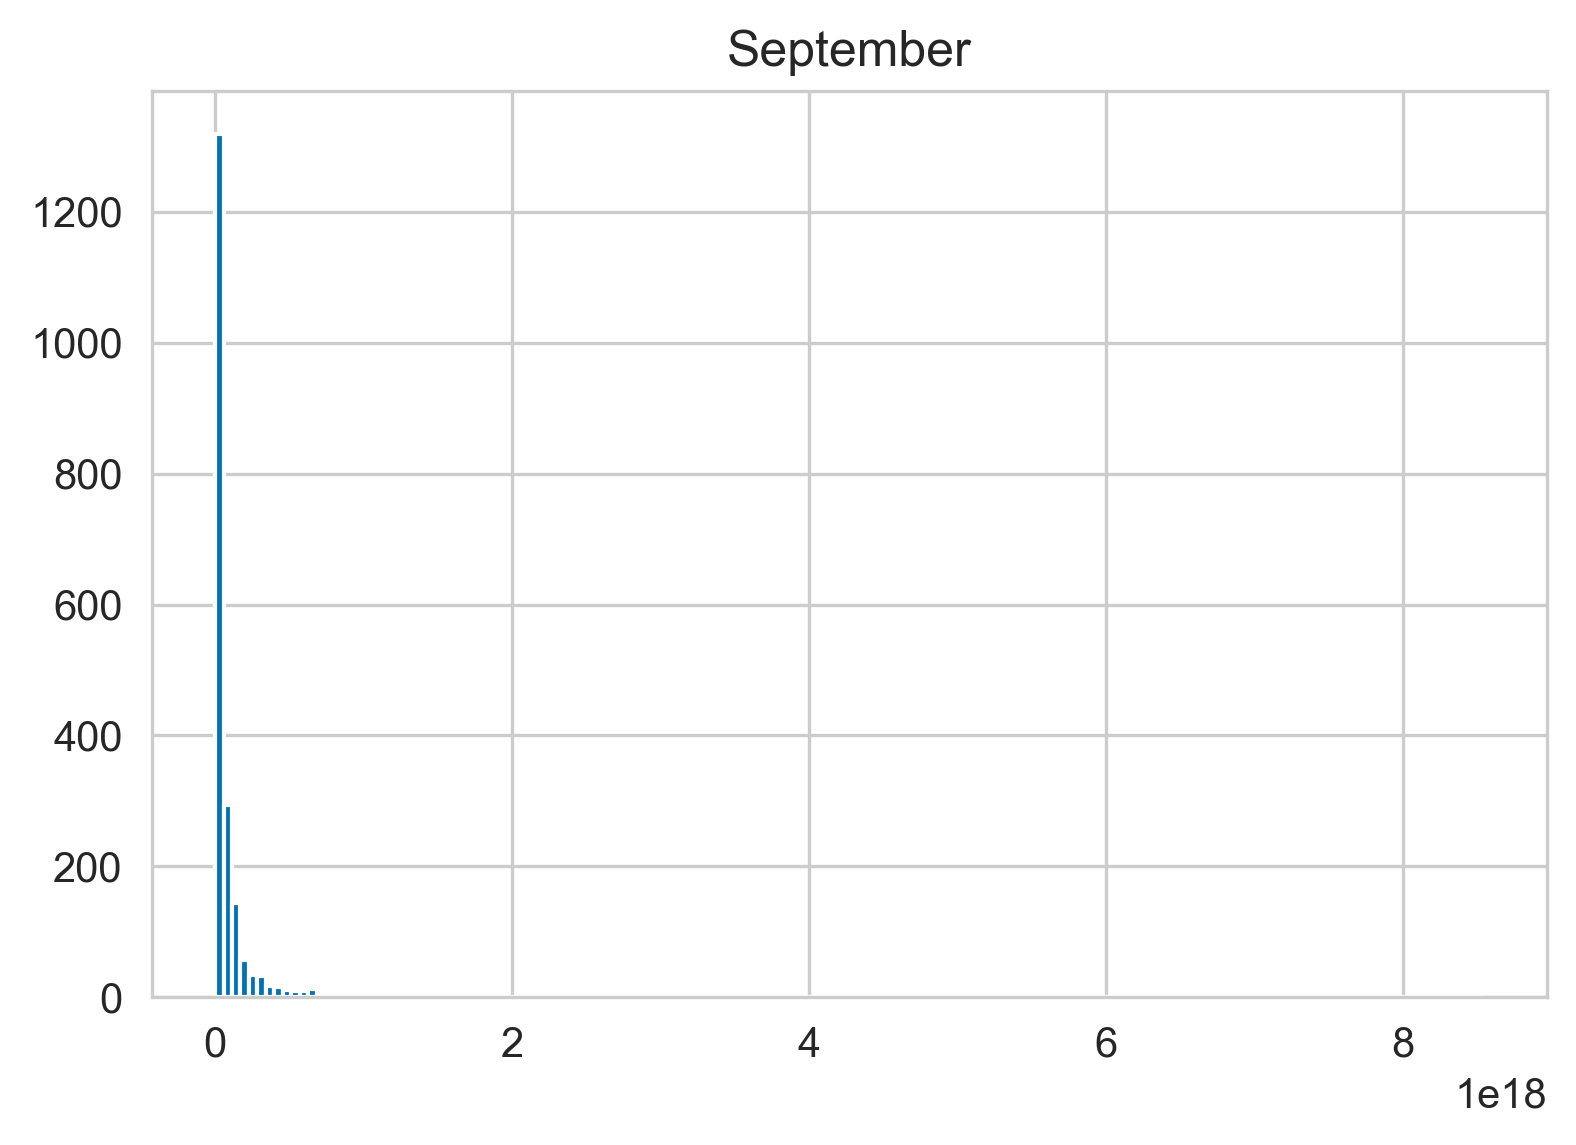

In [32]:
pd.DataFrame(data_september, columns=["September"]).hist(bins = 150)

### 3

Предсказания экспоненциальной модели наверняка получились грустными. Но это, конечно, чересчур пессимистично — экспоненциальный рост в природе никак не может продолжаться вечно. Кривая общего числа заболевших во время эпидемии в реальности имеет сигмоидальный вид: после начальной фазы экспоненциального роста неизбежно происходит насыщение. В качестве конкретной формы такой сигмоиды давайте возьмём форму функции распределения для гауссиана:

![32a01d971c5120525e1742519bd9c4d1ff8a5a91.svg](attachment:32a01d971c5120525e1742519bd9c4d1ff8a5a91.svg)

Естественно, в нашем случае сигмоида стремится не к единице, т.е. константа перед интегралом может быть произвольной (и её можно внести в экспоненту), а в экспоненте под интегралом может быть произвольная квадратичная функция от t.

### 3.a

Предложите способ обучать параметры такой сигмоидальной функции при помощи линейной регрессии.

In [33]:
x = pd.concat([pd.Series(train_days), pd.Series(train_days ** 2)], axis=1)
y = train_data['new_cases']
y = np.log(y)

In [34]:
lr = LinearRegression(fit_intercept=True)
lr.fit(x, y)
coef = lr.coef_
intercept = lr.intercept_

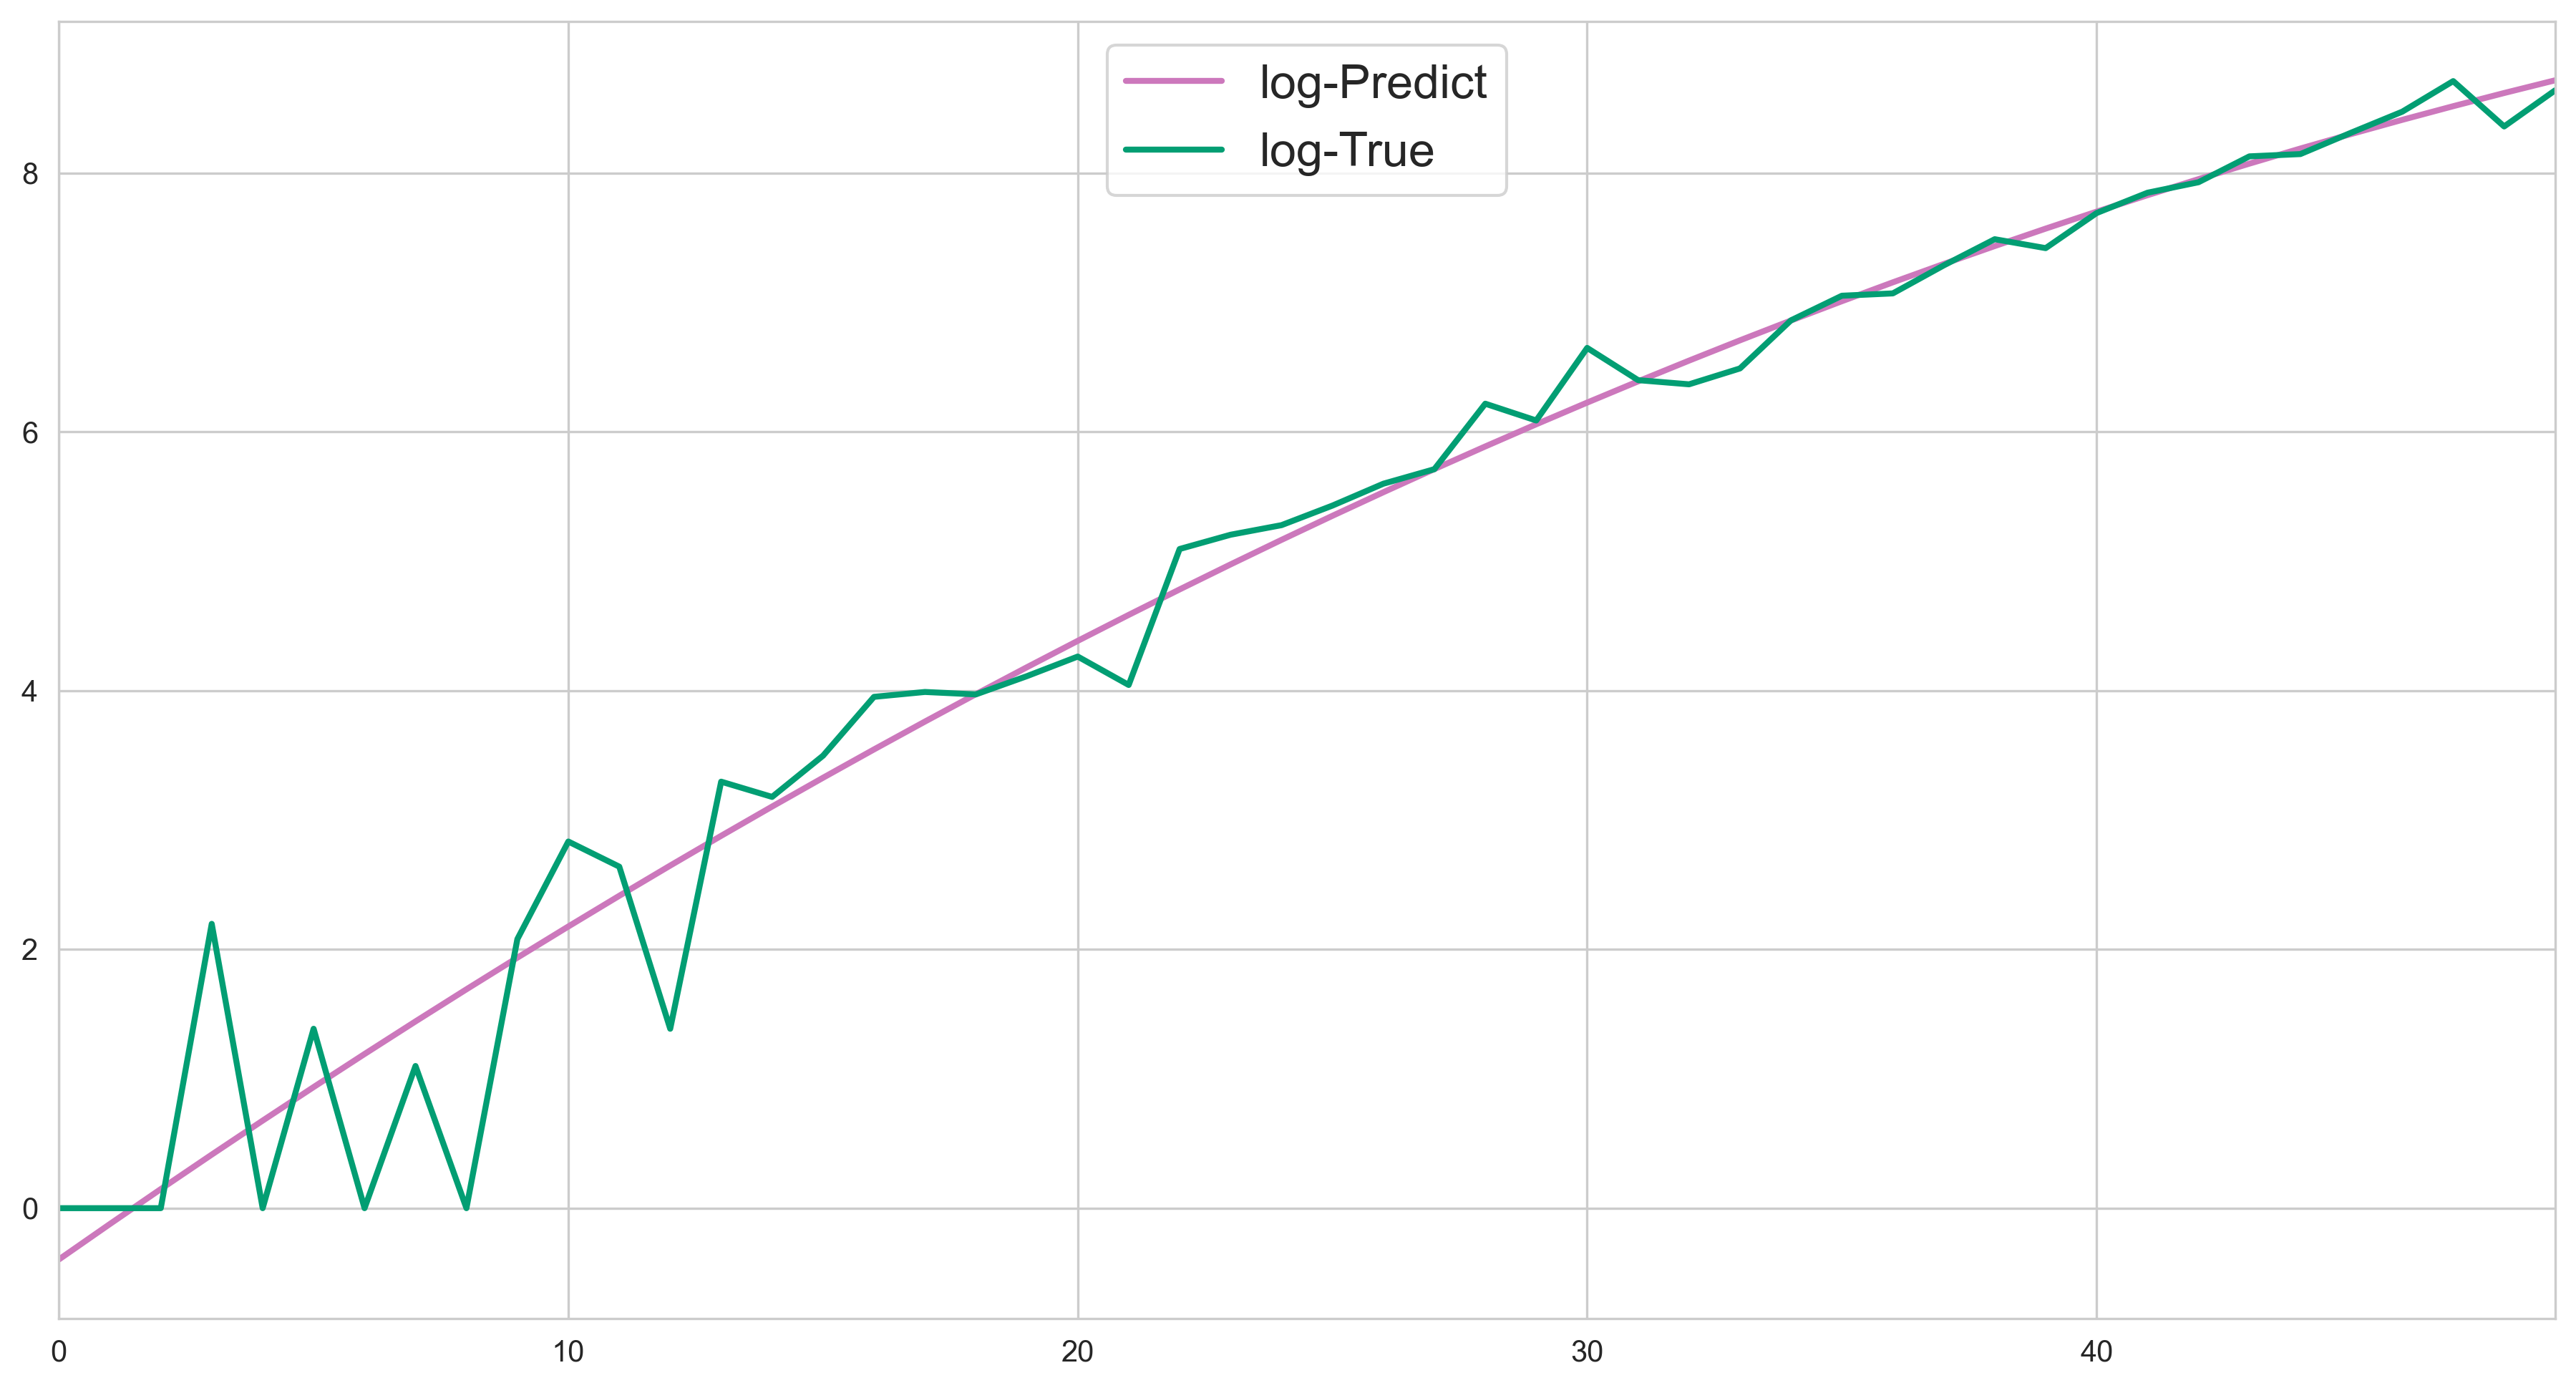

In [35]:
def true_curve(t, coef, intercept):
    return coef[0] * t + coef[1] * (t ** 2) + intercept

predict_new = true_curve(train_days, coef, intercept)

fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)
ax.set_xlim((train_days[0], train_days[-1]))

ax.plot(train_days, predict_new, linewidth=2, label="log-Predict", color=palette[4])
ax.plot(train_days, np.log(train_data['new_cases']), linewidth=2, label="log-True", color=palette[2])

ax.legend(loc="upper center", fontsize=legend_fontsize)
plt.show()

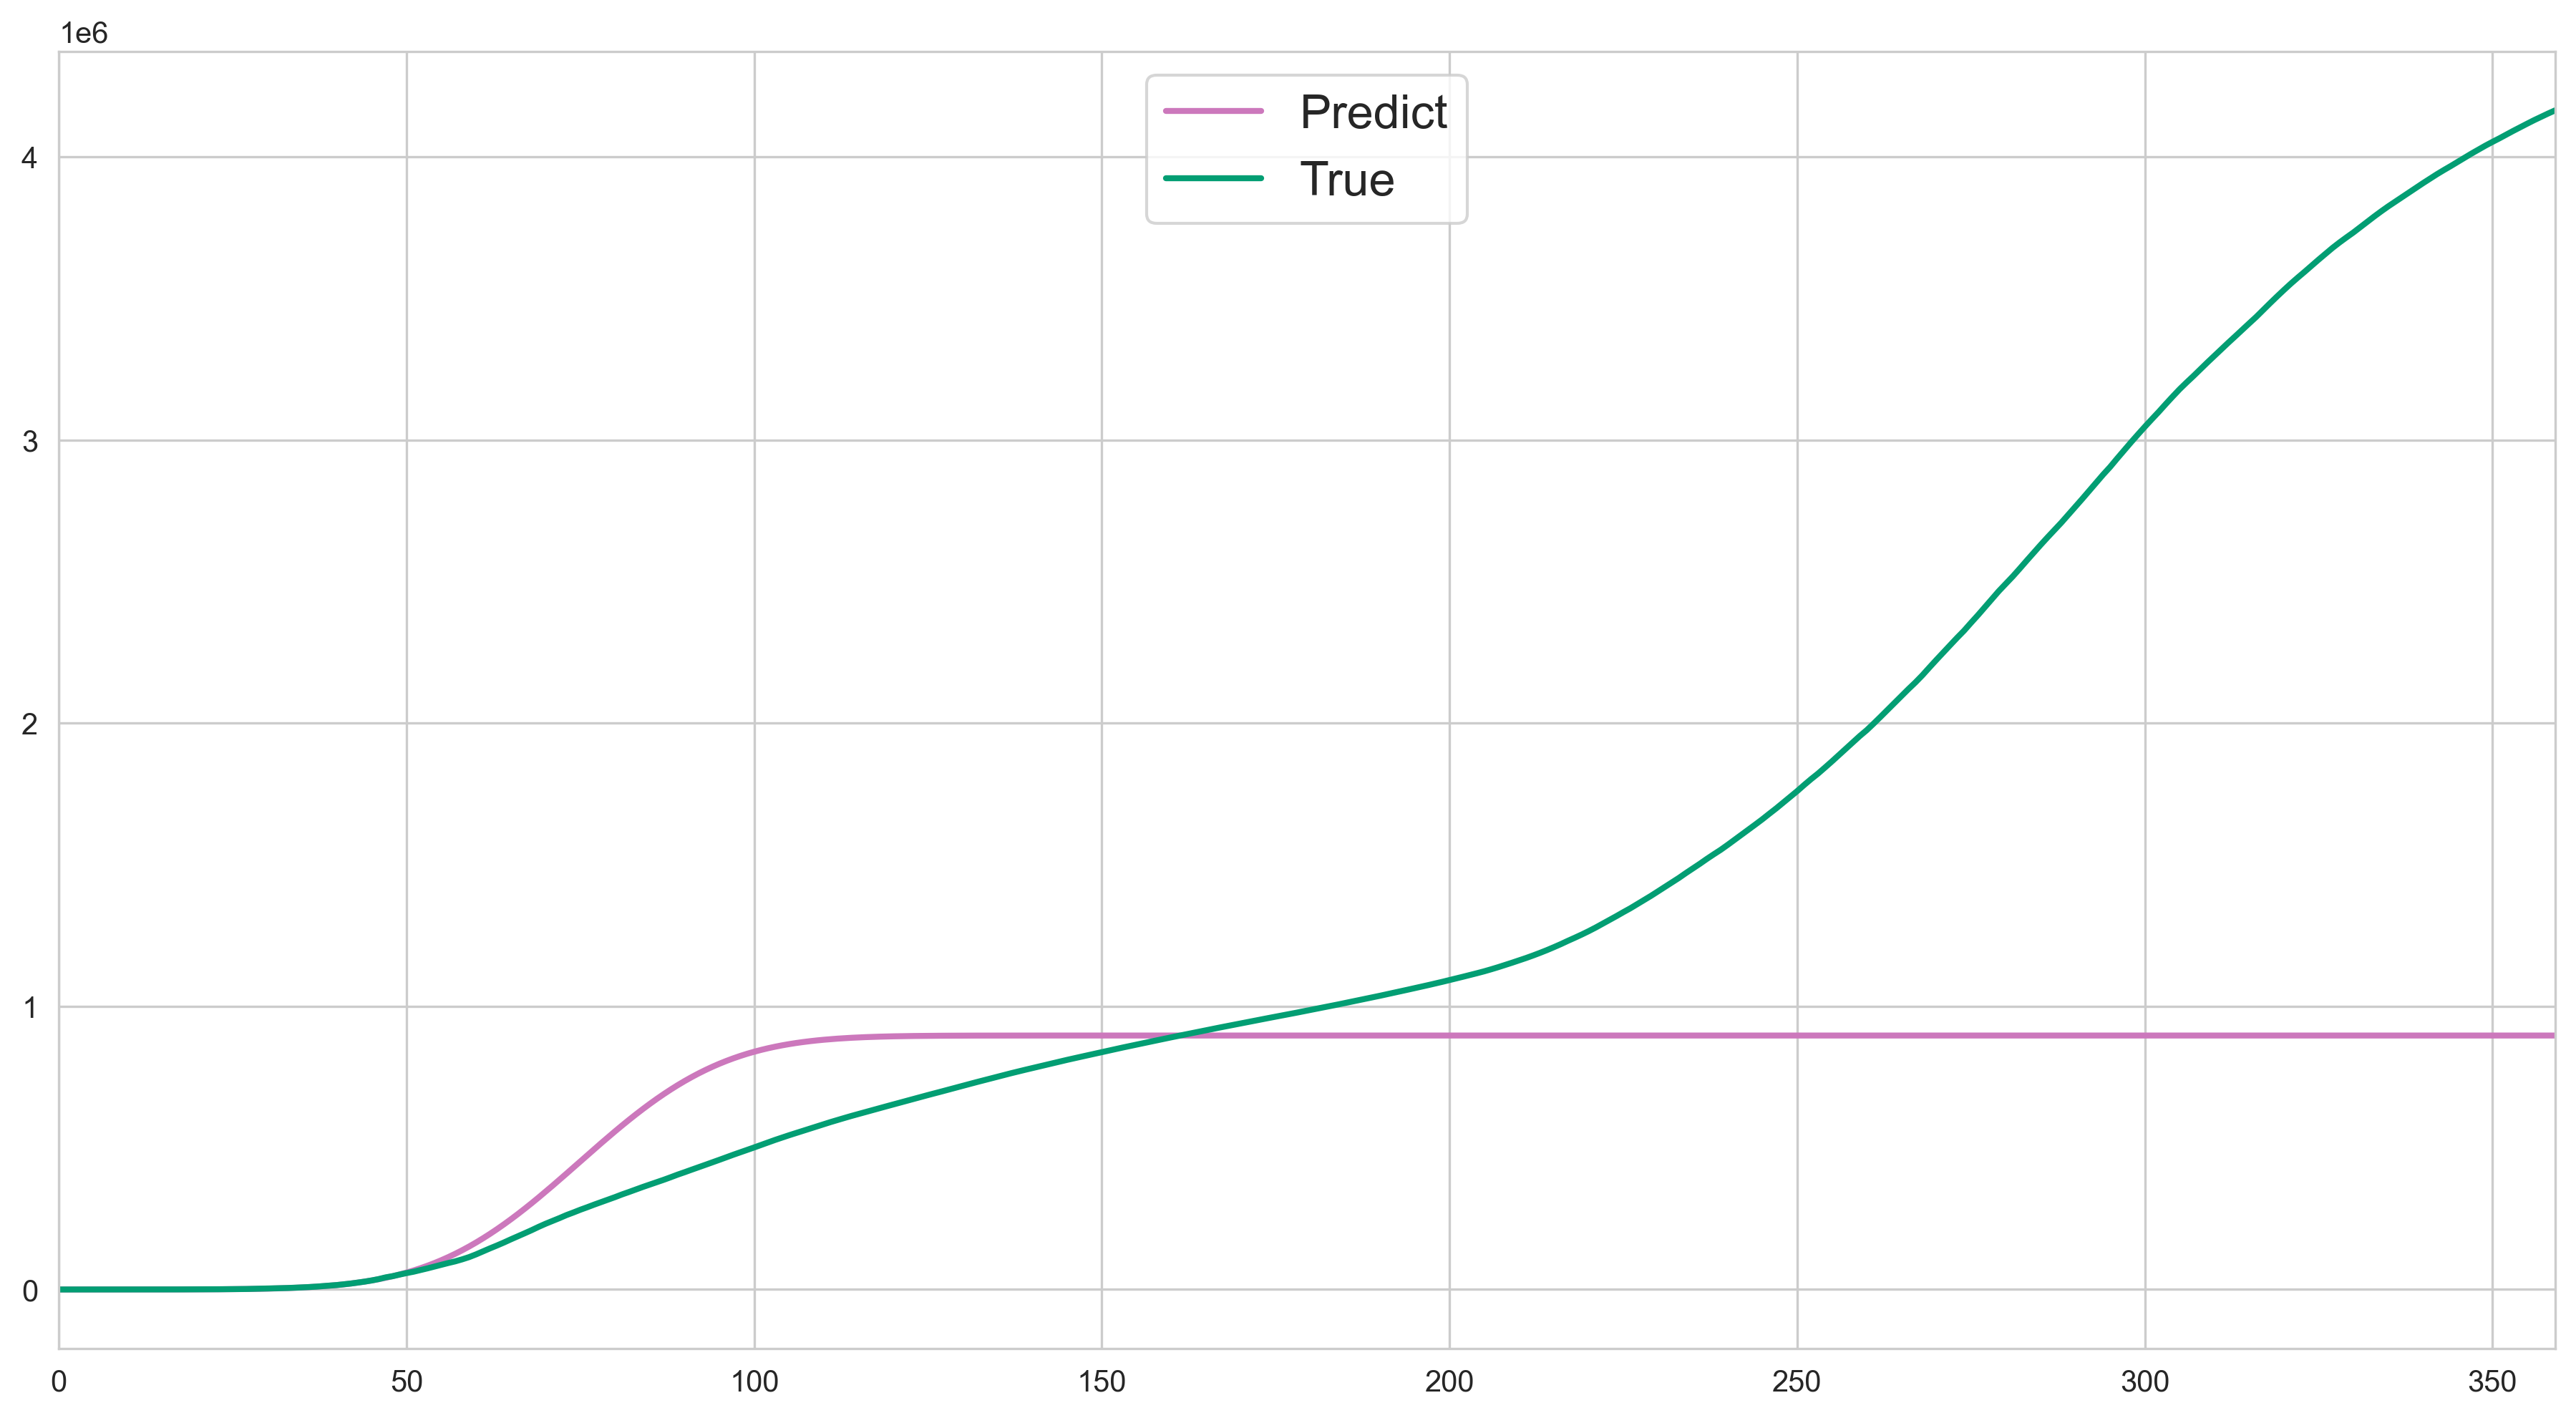

In [36]:
predict_new = np.exp(true_curve(days, coef, intercept))
predict_total = np.zeros(data_size)
prev = 0
for i in range(data_size):
    predict_total[i] = prev + predict_new[i]
    prev = predict_total[i]

fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)
ax.set_xlim((days[0], days[-1]))

ax.plot(days, predict_total, linewidth=2, label="Predict", color=palette[4])
ax.plot(days, data['total_cases'], linewidth=2, label="True", color=palette[2])

ax.legend(loc="upper center", fontsize=legend_fontsize)
plt.show()

### 3.b

Обучите эти параметры на датасете случаев коронавируса в России. Найдите апостериорное распределение параметров этой модели для достаточно широкого априорного распределения. Требующееся для этого значение дисперсии шума в данных оцените, исходя из вашей же максимальной апостериорной модели.

In [37]:
def bayesian_update(mu, sigma, x, y, sigma_noise):
    x_matrix = np.array([[1, x, x ** 2]])
    sigma_n = np.linalg.inv(np.linalg.inv(sigma) + (1 / (sigma_noise ** 2)) * np.matmul(np.transpose(x_matrix), x_matrix) )
    mu_n = np.matmul(sigma_n, np.matmul(np.linalg.inv(sigma), np.transpose(mu)) + (1 / (sigma_noise ** 2)) * np.matmul(np.transpose(x_matrix), np.array([y])))
    return mu_n, sigma_n

In [38]:
def sample_statistics(mu, sigma, xs, n=20):
    my_w = np.random.multivariate_normal(mu, sigma, n)
    res = np.zeros((n, xs.shape[0]))
    for i,w in enumerate(my_w):
        res[i, :] = w[0] + w[1] * xs + w[2] * xs ** 2
    return res

In [39]:
def plot_predictions(xs, mu, x, points, sigma_noise):
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111)
    ax.set_xlim((xs[0], xs[-1]))
    ax.plot(xs, mu[2] * xs ** 2 + mu[1] * xs + mu[0], color="red", label="MAP гипотеза log-new_cases")
    ax.fill_between(xs, mu[2] * xs ** 2 + mu[1] * xs + mu[0] - sigma_noise, mu[2] * xs ** 2 + mu[1] * xs + mu[0] + sigma_noise, color=palette[1], alpha=.3, label="+- дисперсия шума")
    ax.fill_between(xs, np.mean(x, axis=0) - np.std(x, axis=0), np.mean(x, axis=0) + np.std(x, axis=0), color=palette[5], alpha=.2, label="+- дисперсия предсказаний")
    ax.scatter(points[0], points[1], marker='*', s=200)
    ax.legend(fontsize=legend_fontsize)

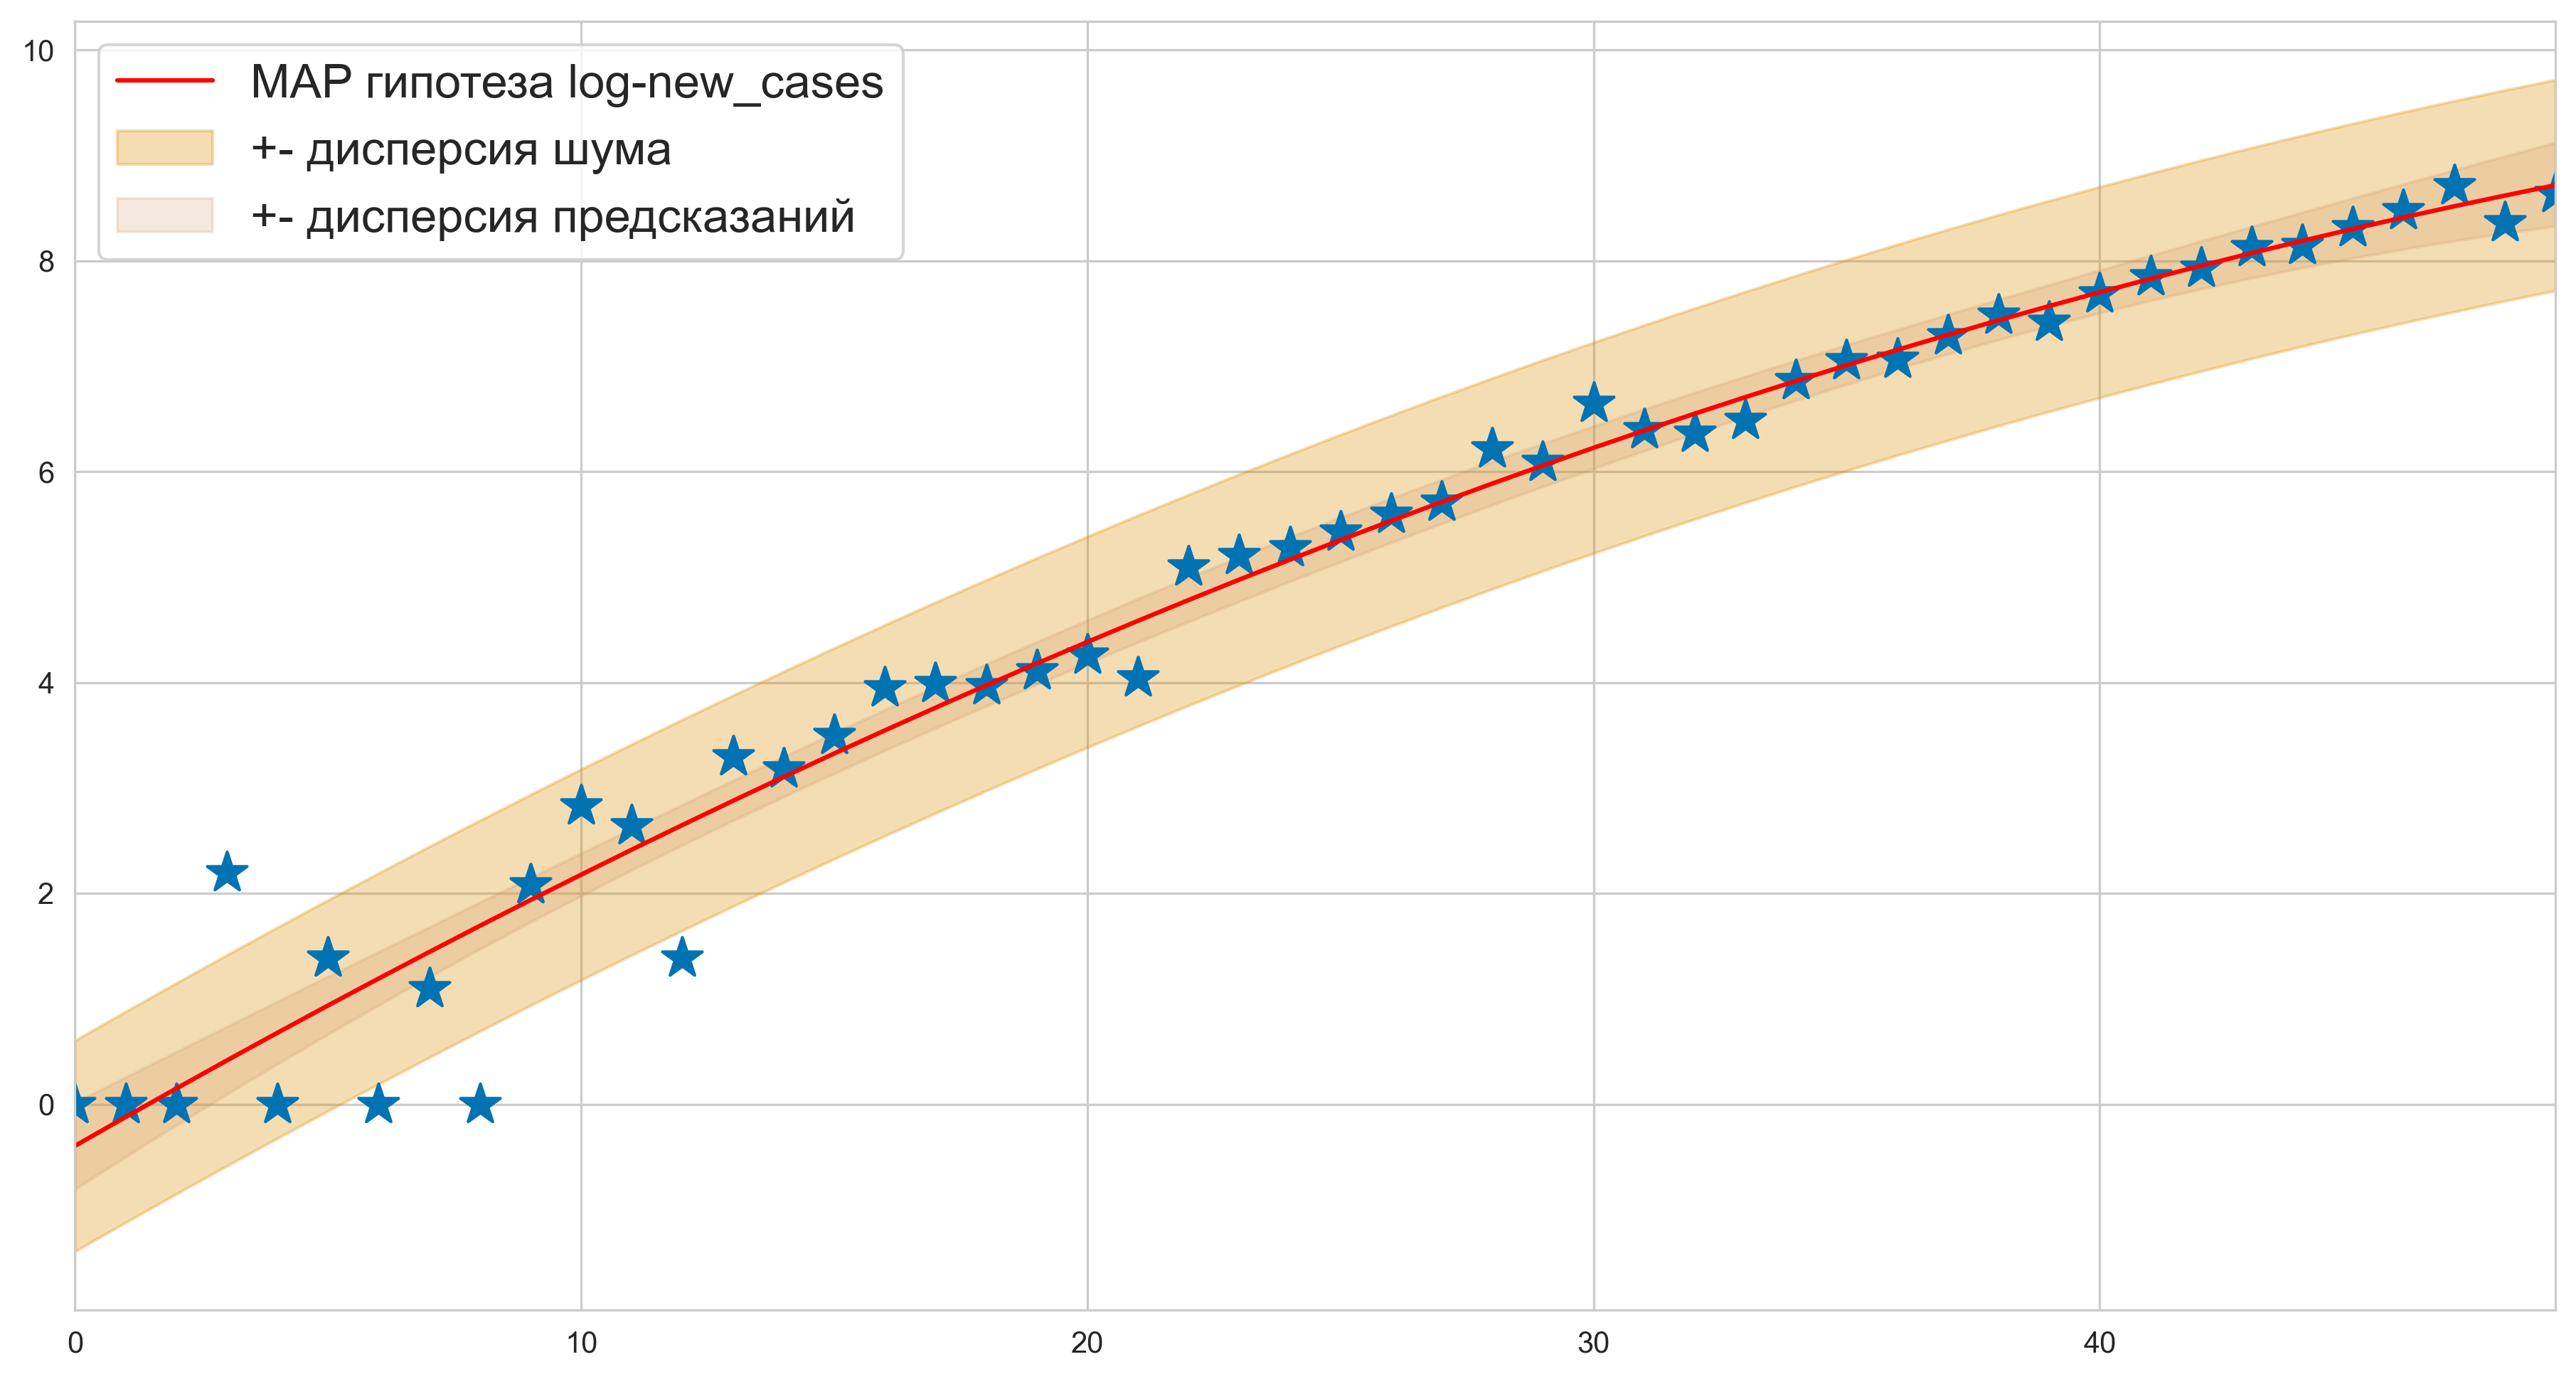

In [40]:
cur_mu, cur_sigma = np.array([0, 0, 0]), 100 * np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]])
lam = 0.01
sigma_noise = lam * 100

px = []
py = []

for i in range(train_size):
    px.append(train_days[i])
    py.append(np.log(train_data['new_cases'][i]))
    #cur_likelihood = get_likelihood(px[-1], py[-1])
    cur_mu, cur_sigma = bayesian_update(cur_mu, cur_sigma, px[-1], py[-1], sigma_noise)    
x = sample_statistics(cur_mu, cur_sigma, train_days, n=2000)
plot_predictions(train_days, cur_mu, x, [px, py], sigma_noise)
plt.show()

### 3.c

Посэмплируйте много разных сигмоид из апостериорного распределения, постройте графики. Сколько, исходя из этих сэмплов, будет всего случаев коронавируса в России? Постройте эмпирическое предсказательное распределение, нарисуйте графики. Каков ваш прогноз числа случаев коронавируса в пессимистичном сценарии (90-й процентиль в выборке числа случаев)? В оптимистичном сценарии (10-й процентиль)?

In [41]:
def sample_statistics_sigmoid(mu, sigma, xs, n=20):
    my_w = np.random.multivariate_normal(mu, sigma, n)
    res = np.zeros((n, xs.shape[0]))
    prev = 0
    for i,w in enumerate(my_w):
        #prev = 0 
        #for j in range(xs.shape[0]):
        res[i, :] = np.exp(w[0] + w[1] * xs + w[2] * xs ** 2)
            #prev = res[i, j]
    return res

In [42]:
def plot_predictions_sigmoid(xs, mu, x, points, sigma_noise):
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111)
    ax.set_xlim((xs[0], xs[-1]))
    ax.set_ylim((0, 1e5))
    ax.plot(xs, np.exp(mu[2] * xs ** 2 + mu[1] * xs + mu[0]), color="red", label="MAP гипотеза new_cases")
    ax.fill_between(xs, np.exp(mu[2] * xs ** 2 + mu[1] * xs + mu[0] - sigma_noise), np.exp(mu[2] * xs ** 2 + mu[1] * xs + mu[0] + sigma_noise), color=palette[1], alpha=.3, label="+- дисперсия шума")
    ax.fill_between(xs, np.mean(x, axis=0) - np.std(x, axis=0), np.mean(x, axis=0) + np.std(x, axis=0), color=palette[5], alpha=.2, label="+- дисперсия предсказаний")
    ax.scatter(points[0], points[1], marker='*', s=200)
    ax.legend(fontsize=legend_fontsize)

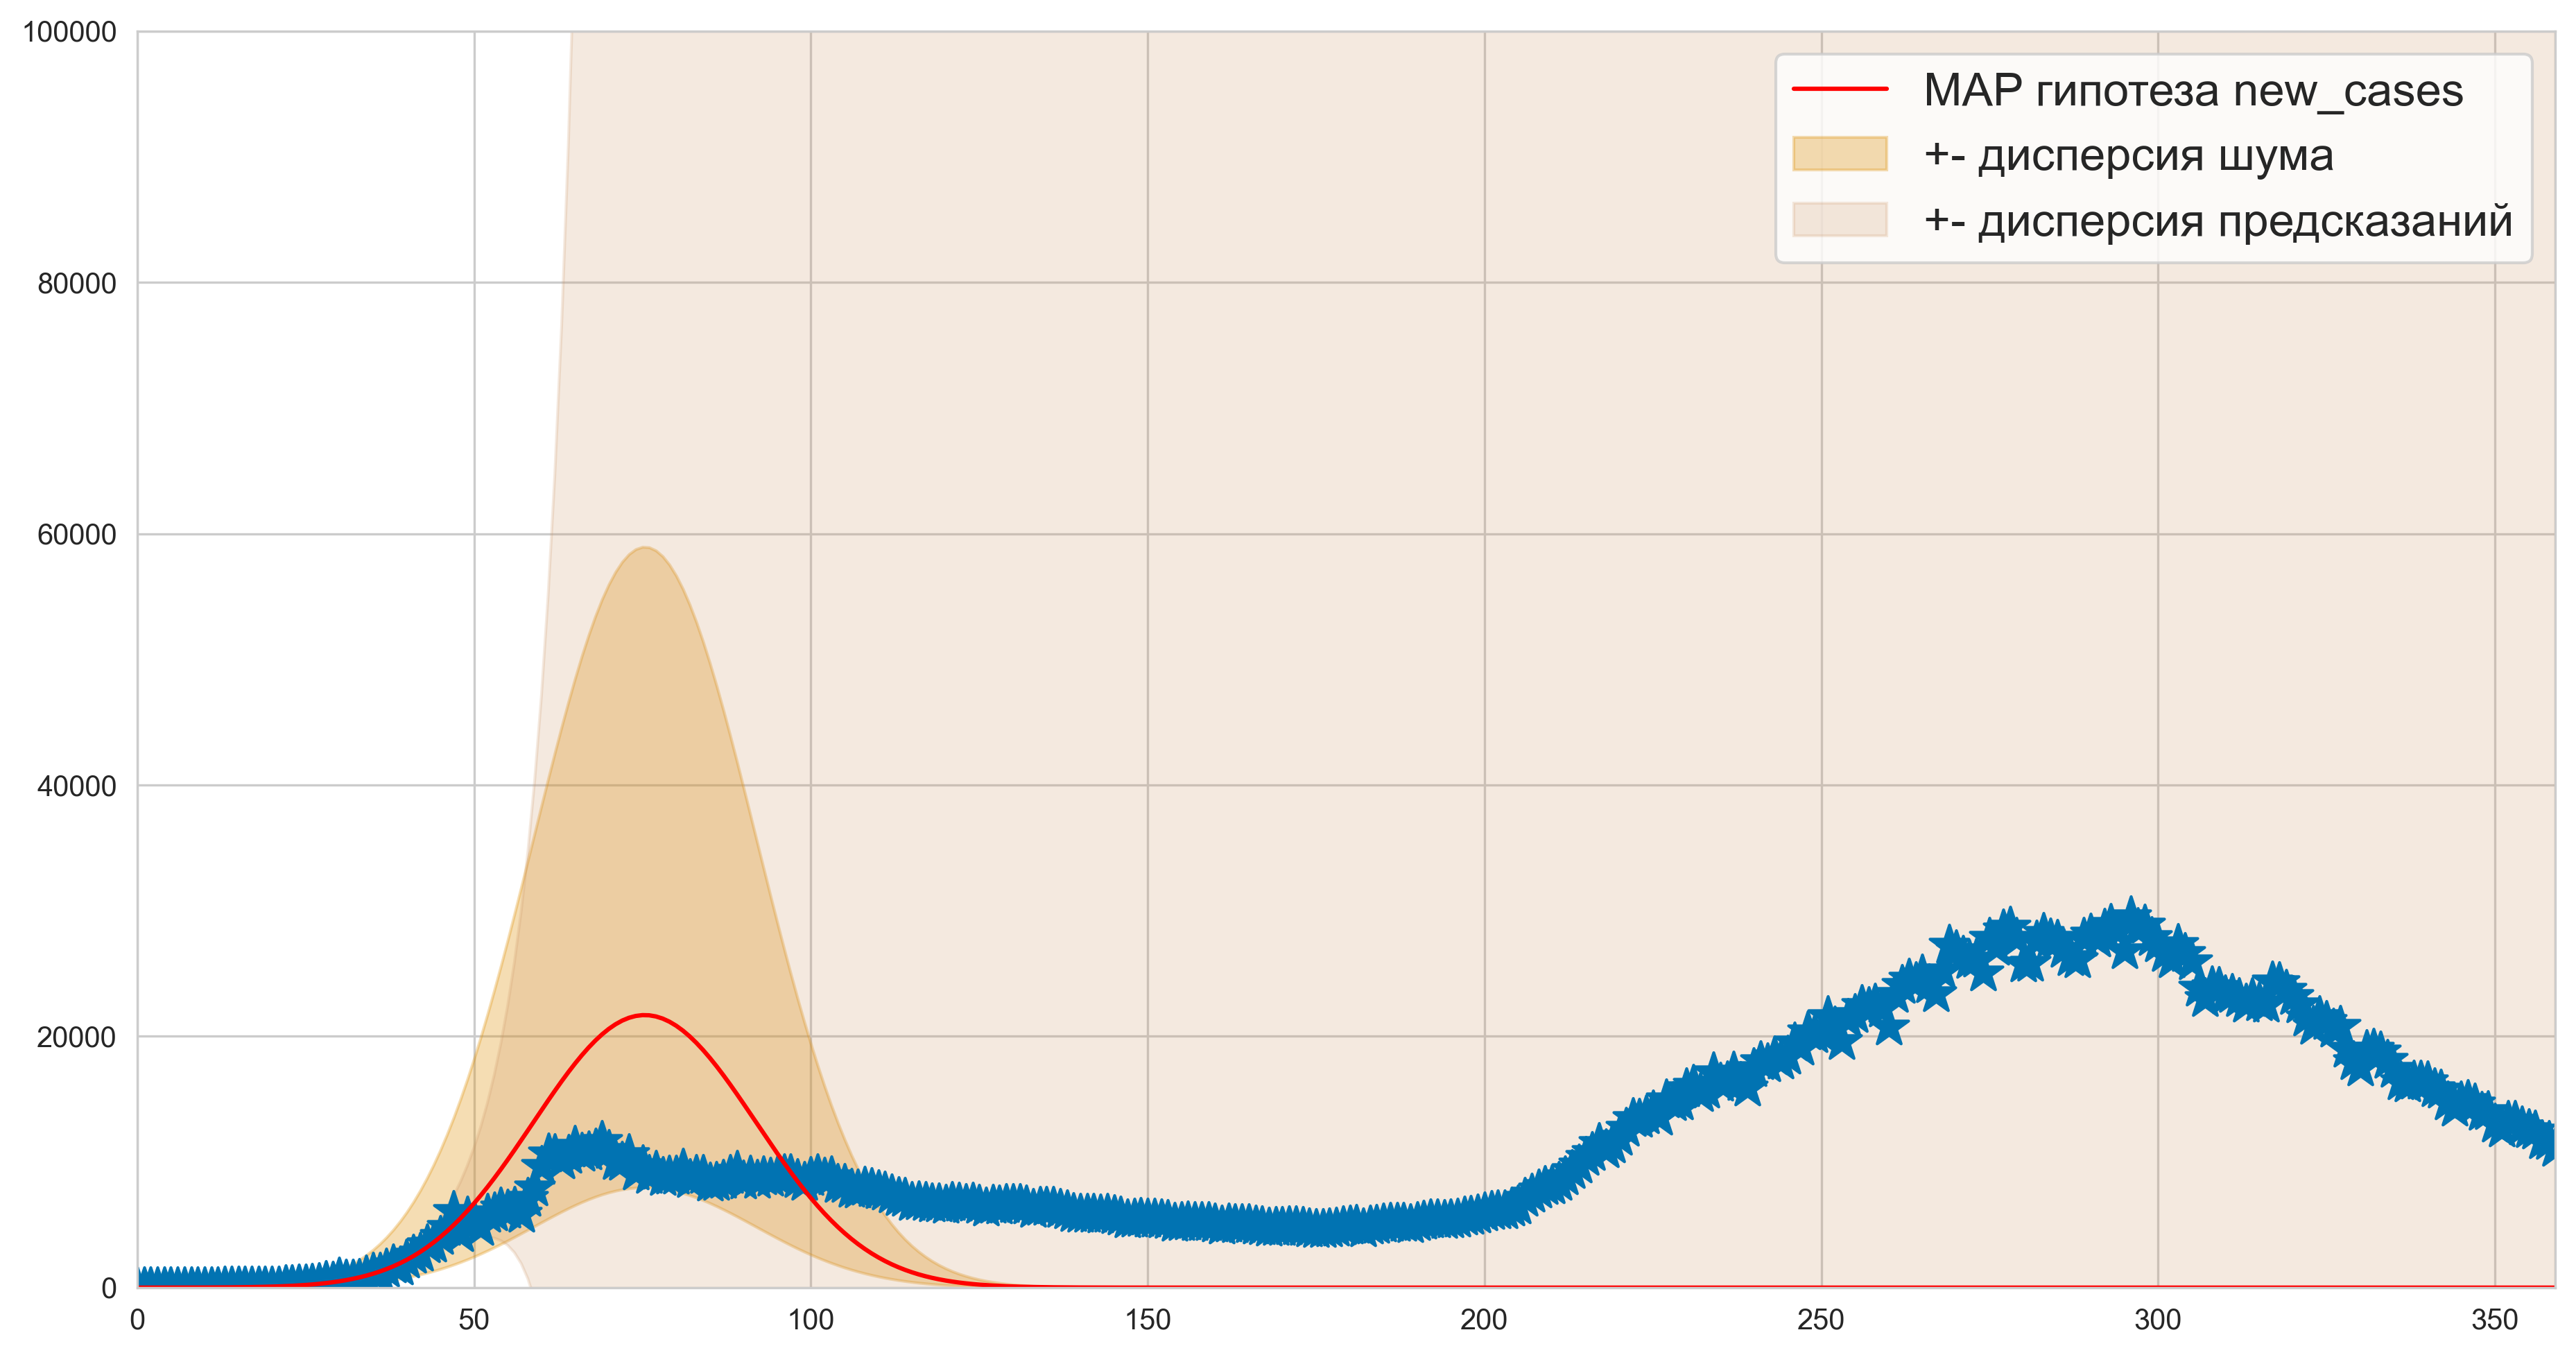

In [43]:
x = sample_statistics_sigmoid(cur_mu, cur_sigma, days, n=2000)
plot_predictions_sigmoid(days, cur_mu, x, [days, data['new_cases']], sigma_noise)
plt.show()

In [44]:
ill = np.exp(cur_mu[2] * days ** 2 + cur_mu[1] * days + cur_mu[0])
summ = np.sum(ill[ill >= 0.5])

In [45]:
print("Исходя из построенного сэмплирования, в России будет всего около {} случаев коронавируса.".format(round(summ)))

Исходя из построенного сэмплирования, в России будет всего около 899002 случаев коронавируса.


array([[<AxesSubplot:title={'center':'total number of patients'}>]],
      dtype=object)

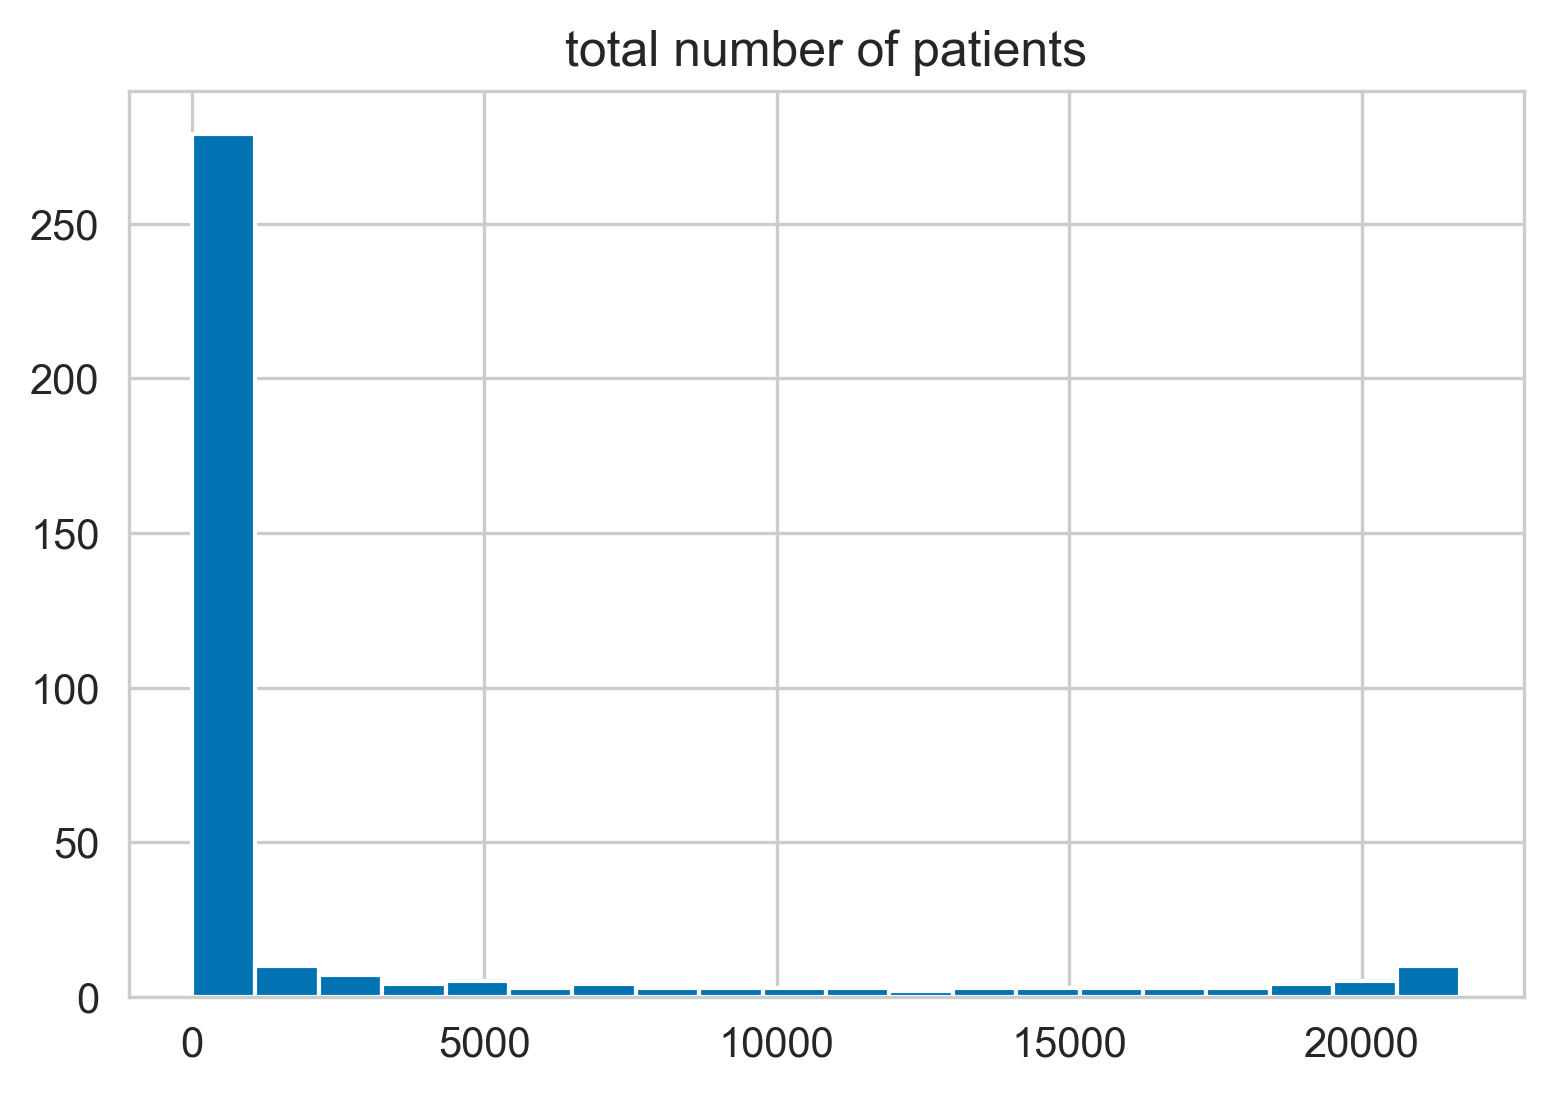

In [46]:
pd.DataFrame(ill, columns=["total number of patients"]).hist(bins = 20)

In [47]:
ill_90 = np.percentile(ill, 90)
ill_90 = np.sum(ill[ill >= ill_90])
ill_10 = np.percentile(ill, 10)
ill_10 = np.sum(ill[ill >= ill_10])

In [48]:
print("При оптимистичном сценарии общее количество случаев короновируса в России достигнет {}.".format(round(ill_90)))
print("При пессимистичном сценарии общее количество случаев короновируса в России достигнет {}.".format(round(ill_10)))

При оптимистичном сценарии общее количество случаев короновируса в России достигнет 650633.
При пессимистичном сценарии общее количество случаев короновируса в России достигнет 899004.
